# Polarization Jacobians

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [7]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats as ss
from scipy.integrate import trapz
import seaborn as sns

sns.set(context='notebook', palette='colorblind', style='ticks',
        font='serif', font_scale=1.5)
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

## Example

Create an example of Jacobians and integration limits.

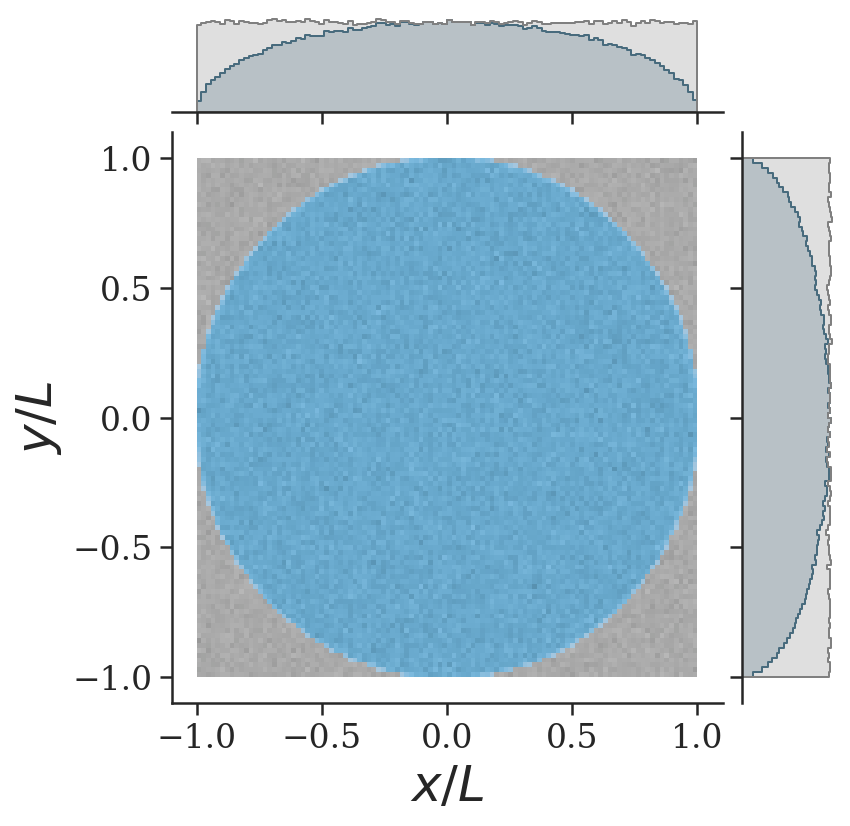

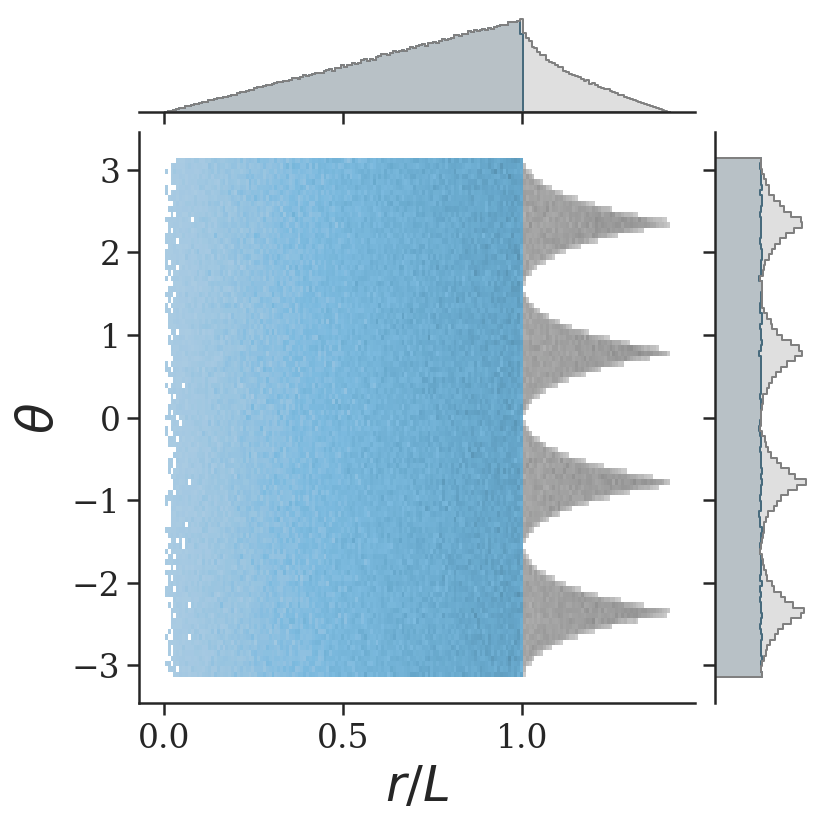

In [896]:
N = 500000
rng = np.random.default_rng(12345)

xmax = 1
x = rng.uniform(-xmax, xmax, N)
y = rng.uniform(-xmax, xmax, N)

k = dict(x='$x/L$', y='$y/L$', r='$r/L$', t=r'$\theta$')

df = pd.DataFrame({k['x']: x, k['y']: y, 'range': 'full'})
df[k['r']] = np.sqrt(x**2 + y**2)
df[k['t']] = np.arctan2(y, x)

df2 = df[df[k['r']]<= xmax].copy()
df2['range'] = 'restricted'

df = df.append(df2, ignore_index=True)

gkws = dict(data=df, hue='range', joint_kws=dict(alpha=0.9, rasterized=True),
            marginal_kws=dict(element='step'), #palette=sns.color_palette(['gray', 'blue'])
            )

p = sns.color_palette(['gray', sns.color_palette('colorblind', desat=0.4)[0]])
sns.set(context='notebook', palette=p, style='ticks',
        font='serif', font_scale=1.5)

for i, (k1, k2) in enumerate([(k['x'], k['y']), (k['r'], k['t'])]):
    g = sns.jointplot(x=k1, y=k2, kind='hist', **gkws)
#     g = sns.JointGrid(x=k1, y=k2, **gkws)
#     g.plot_joint(sns.scatterplot, alpha=0.7)
#     g.plot_marginals(sns.histplot)
    g.ax_joint.get_legend().remove();
    g.ax_joint.xaxis.label.set_size(25);
    g.ax_joint.yaxis.label.set_size(25);
    plt.savefig(f"jac_example_{i}.pdf", bbox_inches='tight')

sns.set(context='notebook', palette='colorblind', style='ticks',
        font='serif', font_scale=1.5)

In [592]:
# !mv jac_example_*.pdf ../fig/

## Intensity amplitude and $\chi$

In [593]:
# !pip install nmmn

In [594]:
# import nmmn.plots
# wolfram=nmmn.plots.wolframcmap()

### Forward transformation

In [672]:
def inv_jac_Achi_to_Aep(e):
    j = 1/np.sqrt(1 + e**2)
    return j / trapz(j, e)

In [677]:
N = 1000000
rng = np.random.default_rng(12345)

# draw uniformly in the original quantities
Ahatmax = np.sqrt(2)
Ahat = rng.uniform(0, Ahatmax, N)
chi = rng.uniform(-np.pi/4, np.pi/4, N)

# transform into A, ellipticity
A = Ahat*np.cos(chi)
e = np.tan(chi)

# plot distribution and Jacobian

Amax = Ahatmax/np.sqrt(2)

# sns.distplot(e[A<=Amax])

# es = np.linspace(-0.999, 0.999, 100)
# plt.plot(es, inv_jac_Achi_to_Aep(es), label=r'$\propto 1/J$')
# plt.legend();
# plt.xlabel(r'$\epsilon$');
# plt.figure()

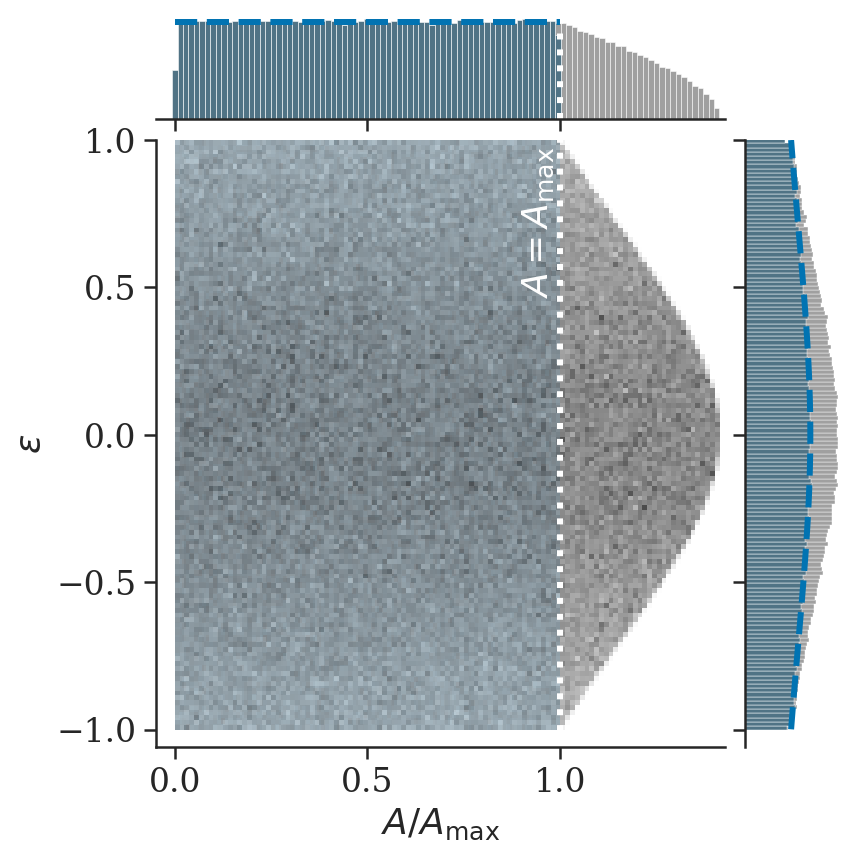

In [679]:
Nplot = np.inf

ix = rng.choice(len(A), min(Nplot, len(A)), replace=False)
x = A[ix]
y = e[ix]

xkdemax = max(A)*1.01
br = (-0.99*xkdemax, xkdemax)
c = sns.color_palette('colorblind', desat=0.4)[0]
marg_kws = dict(binrange=br, bins=200, stat='count')
joint_kws = dict(gridsize=64, extent=[0, xkdemax,-1,1], alpha=0.5)

# g = sns.JointGrid(x=x, y=y, xlim=(-0.05, xkdemax), ylim=(-1.06,1))
# g.plot_joint(sns.histplot, cmap='Greys', alpha=0.9)
# g.plot_marginals(sns.histplot, color='gray', **marg_kws)

# g.x = g.x[x <= Amax]
# g.y = g.y[x <= Amax]
# g.plot_joint(sns.histplot, cmap='Blues', alpha=0.9)
# g.plot_marginals(sns.histplot, color=c, **marg_kws)

g = sns.JointGrid(x=x, y=y, xlim=(-0.05, xkdemax), ylim=(-1.06,1))
g.plot_joint(sns.histplot, cmap='Greys', alpha=.7)#,  **joint_kws)
g.plot_marginals(sns.histplot, color='gray', **marg_kws)

g.x = g.x[x <= Amax]
g.y = g.y[x <= Amax]
g.plot_joint(sns.histplot, bins=100, color=c, alpha=0.25)
g.plot_marginals(sns.histplot, color=c, **marg_kws)

g.ax_joint.set_xlabel(r'$A/A_{\rm max}$')
g.ax_joint.set_ylabel(r'$\epsilon$');
g.ax_joint.set_yticks([-1, -0.5, 0, 0.5, 1])
g.ax_joint.plot([],[], label='full', c='gray')
g.ax_joint.plot([],[], label='restricted', c=c)
# g.ax_joint.legend(framealpha=0.5);

lkws = dict(c='w', ls=':', lw=3)
g.ax_joint.axvline(Amax, **lkws);
g.ax_marg_x.axvline(Amax, **lkws);

As = np.linspace(0, Amax, 100)
cjac = sns.color_palette()[0]

nbins = marg_kws['bins'] * Amax / (0.99*xkdemax)
c = 2*len(g.x) / nbins
g.ax_marg_x.plot(As, np.ones(len(As))*c, lw=3, ls='--', c=cjac)

sns.histplot(e[A<=Amax], ax=axins, stat='density', color='w', alpha=0.5)

es = np.linspace(-0.999, 0.999, 100)
c = 2*np.sqrt(2)*len(g.x) / marg_kws['bins']
g.ax_marg_y.plot(inv_jac_Achi_to_Aep(es)*c, es, c=cjac, ls='--', lw=3)

g.ax_joint.annotate(r"$A=A_\mathrm{max}$",
            xy=(Amax, 1), xycoords='data', rotation=90,
            xytext=(-2, -3), textcoords='offset points',
            horizontalalignment='right', verticalalignment='top',
            color=lkws['c']);
plt.savefig("jac_Aeps_Achi.pdf", bbox_inches='tight')

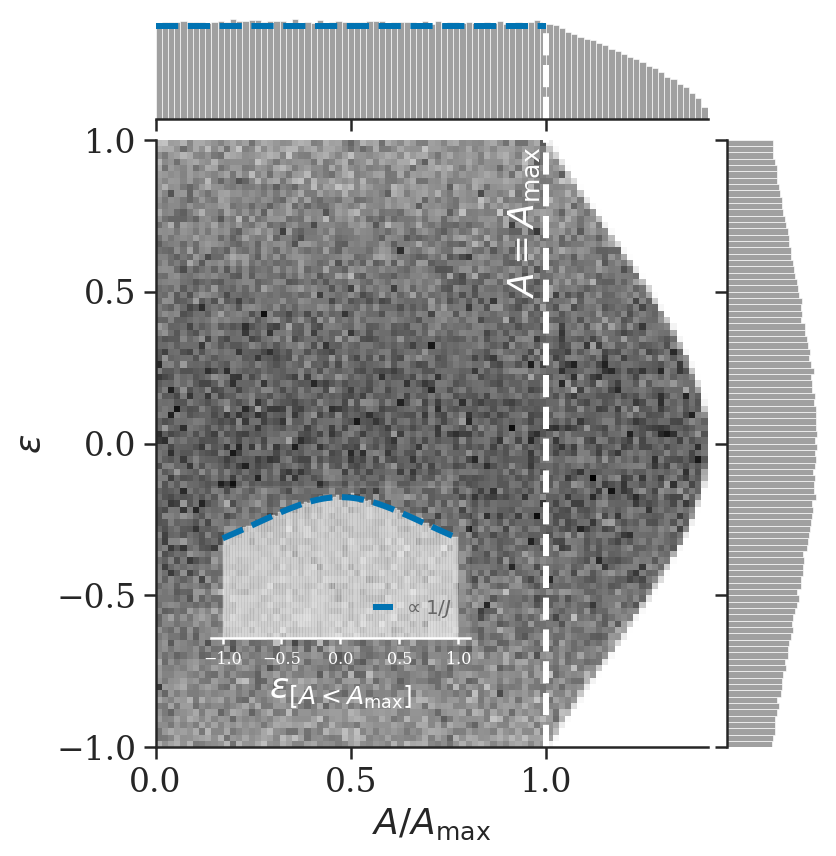

In [25]:
Nplot = np.inf

ix = rng.choice(len(A), min(Nplot, len(A)), replace=False)
x = np.concatenate((A[ix], -A[ix]))
y = np.concatenate((e[ix], e[ix]))
x = A[ix]
y = e[ix]

xkdemax = max(A)*1.01
g = sns.jointplot(x=x, y=y, xlim=(0, 0.99*xkdemax), ylim=(-1,1), kind='hist', 
                  cmap='Greys', marginal_kws=dict(stat='density', color='gray'),
                 joint_kws=dict(alpha=1))

g.ax_joint.set_xlabel(r'$A/A_{\rm max}$')
g.ax_joint.set_ylabel(r'$\epsilon$');

g.ax_joint.set_yticks([-1, -0.5, 0, 0.5, 1])

lkws = dict(c='w', ls='--', lw=3)
g.ax_joint.axvline(Amax, **lkws);
g.ax_marg_x.axvline(Amax, **lkws);

As = np.linspace(0, Amax, 100)
cjac = sns.color_palette()[0]
g.ax_marg_x.plot(As, 1.9*np.ones(len(As))/(2.5),
                 c=cjac, lw=3, ls='--')

axins = g.ax_joint.inset_axes([0.1, 0.18, 0.47, 0.25])
axins.tick_params(labelsize=8, #direction='in', 
                  labelcolor='w', color='w', length=3)

sns.histplot(e[A<=Amax], ax=axins, stat='density',
             color='w', alpha=0.5)

es = np.linspace(-0.999, 0.999, 100)
axins.plot(es, inv_jac_Achi_to_Aep(es), c=cjac,
           label=r'$\propto 1/J$', ls='--',
           lw=3)
axins.set_xlabel(r'$\epsilon_{[A < A_{\rm max}]}$', color='w')
axins.set_ylabel(None);
axins.set_yticks([]);
axins.patch.set_alpha(0.1);
for k in ['top', 'right', 'left']:
    axins.spines[k].set_visible(False)
axins.spines['bottom'].set_color('w')
axins.legend(fontsize=10, frameon=False, labelcolor='0.4', loc='lower right',
             handlelength=1, handletextpad=0.5);

# sns.despine(g.ax_joint.figure)
g.ax_joint.annotate(r"$A=A_\mathrm{max}$",
            xy=(Amax, 1), xycoords='data', rotation=90,
            xytext=(-2, -3), textcoords='offset points',
            horizontalalignment='right', verticalalignment='top',
            color=lkws['c']);
# plt.savefig("jac_Aeps_Achi.pdf", bbox_inches='tight')

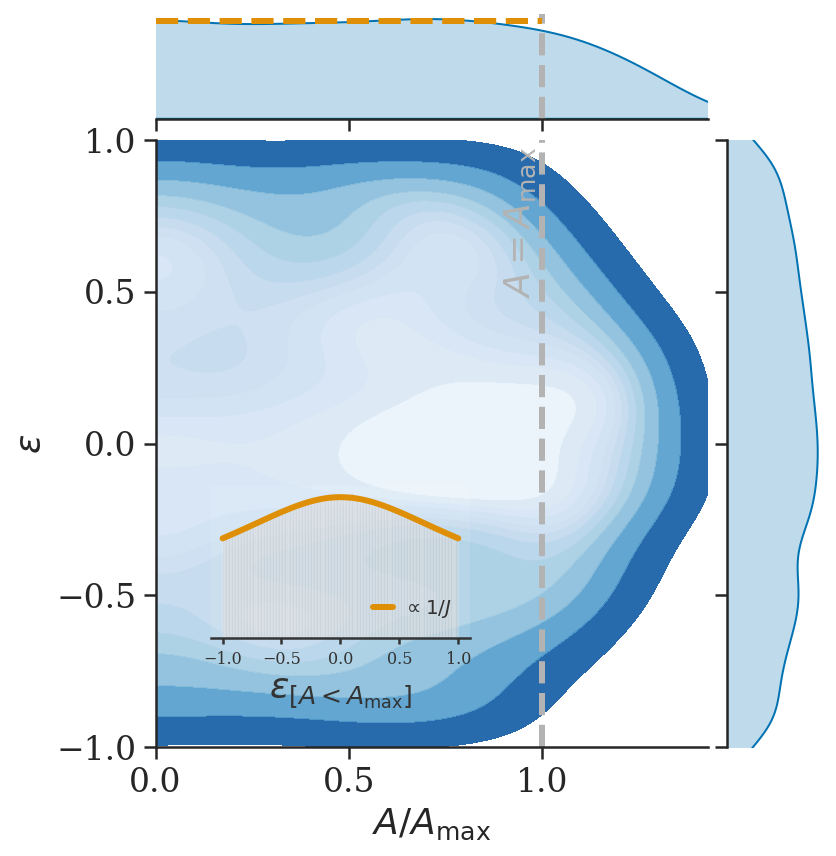

In [462]:
Nplot = 5000

ix = rng.choice(len(A), min(Nplot, len(A)), replace=False)
x = np.concatenate((A[ix], -A[ix]))
y = np.concatenate((e[ix], e[ix]))

xkdemax = max(A)*1.01
g = sns.jointplot(x=x, y=y, xlim=(0, xkdemax), ylim=(-1,1), kind='kde', 
                  joint_kws=dict(clip=((0,2), (-1,1)), levels=12, fill=True, alpha=0.9, cmap='Blues_r',))

g.ax_joint.set_xlabel(r'$A/A_{\rm max}$')
g.ax_joint.set_ylabel(r'$\epsilon$');

g.ax_joint.set_yticks([-1, -0.5, 0, 0.5, 1])

lkws = dict(c='0.7', ls='--', lw=3)
g.ax_joint.axvline(Amax, **lkws);
g.ax_marg_x.axvline(Amax, **lkws);

# g.ax_joint.tick_params(direction='in')

As = np.linspace(0, Amax, 100)
g.ax_marg_x.plot(As, np.ones(len(As))/(2.5),
                 c=sns.color_palette()[1],
                 lw=3, ls='--')

cins = '0.2'
axins = g.ax_joint.inset_axes([0.1, 0.18, 0.47, 0.25])
axins.tick_params(labelsize=8, #direction='in', 
                  labelcolor=cins, color=cins, length=3)

sns.histplot(e[A<=Amax], ax=axins, stat='density',
             color='0.8', alpha=0.5)

es = np.linspace(-0.999, 0.999, 100)
axins.plot(es, inv_jac_Achi_to_Aep(es),
           c=sns.color_palette()[1],
           label=r'$\propto 1/J$',
           lw=3)
axins.set_xlabel(r'$\epsilon_{[A < A_{\rm max}]}$', color=cins)
axins.set_ylabel(None);
axins.set_yticks([]);
axins.patch.set_alpha(0.1);
for k in ['top', 'right', 'left']:
    axins.spines[k].set_visible(False)
axins.spines['bottom'].set_color(cins)
axins.legend(fontsize=10, frameon=False, labelcolor=cins, loc='lower right',
             handlelength=1, handletextpad=0.5);

# sns.despine(g.ax_joint.figure)
g.ax_joint.annotate(r"$A=A_\mathrm{max}$",
            xy=(Amax, 1), xycoords='data', rotation=90,
            xytext=(-2, -3), textcoords='offset points',
            horizontalalignment='right', verticalalignment='top',
            color=lkws['c']);
# plt.savefig("jac_Aeps_Achi_kde.pdf", bbox_inches='tight')

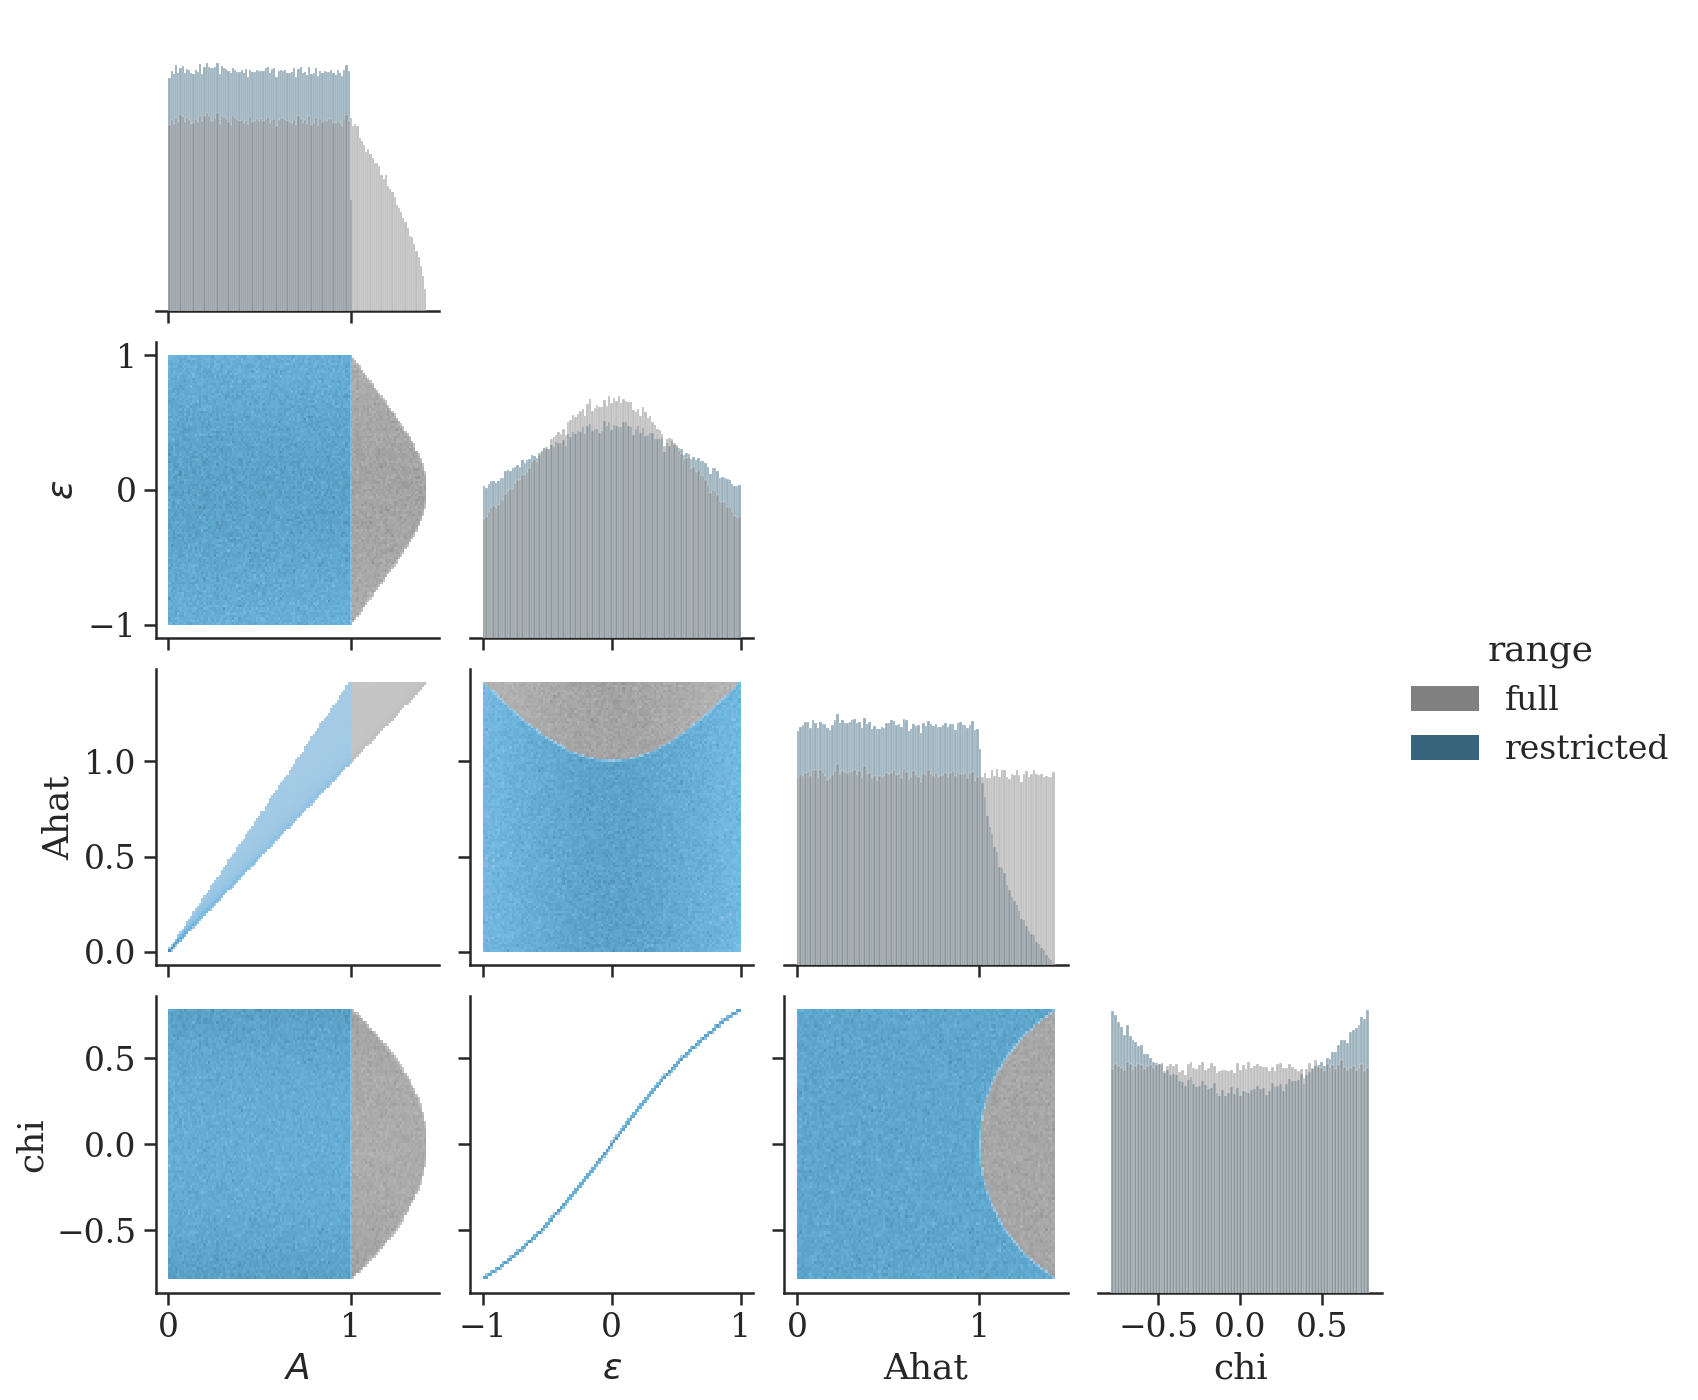

In [534]:
Nplot = np.inf

ix = rng.choice(len(A), min(Nplot, len(A)), replace=False)
df = pd.DataFrame({'$A$': A[ix], r'$\epsilon$': e[ix], 'Ahat': Ahat[ix], 'chi': chi[ix]})
df2 = df[(df['$A$']< Amax)].copy()

df = df.iloc[:len(df2)]
df['range'] = 'full'
df2['range'] = 'restricted'
df = df.append(df2, ignore_index=True)

p = sns.color_palette(['gray', sns.color_palette('colorblind', desat=0.4)[0]])
sns.set(context='notebook', palette=p, style='ticks',
        font='serif', font_scale=1.5)

ks = ['$A$', r'$\epsilon$', 'range']
sns.pairplot(df, kind='hist', corner=True, hue='range', diag_kws=dict(stat='count'))

sns.set(context='notebook', palette='colorblind', style='ticks',
        font='serif', font_scale=1.5)

### Backward transformation

In [463]:
def inv_jac_Aep_to_Achi(chi):
    j = 1/np.cos(chi)
    return j / trapz(j, chi)

<Figure size 432x288 with 0 Axes>

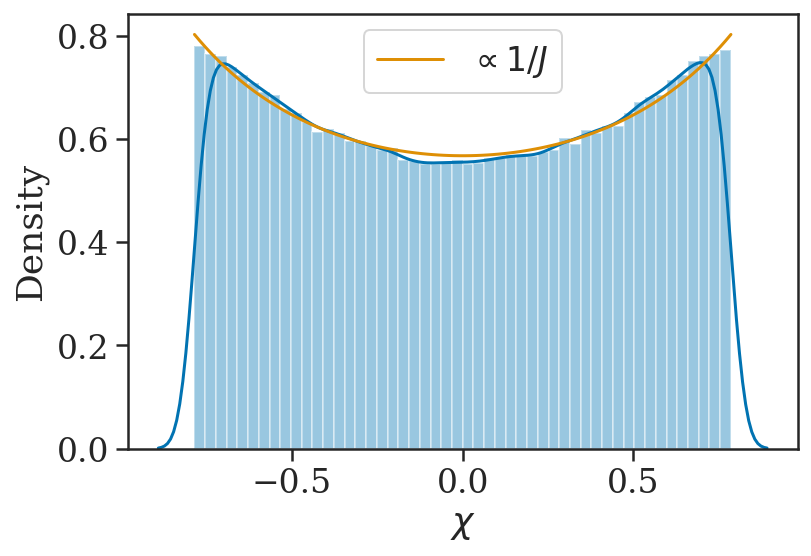

<Figure size 432x288 with 0 Axes>

In [464]:
N = 500000
rng = np.random.default_rng(12345)

# draw uniformly in the original quantities
Amax = 1
A = rng.uniform(0, 1, N)
e = rng.uniform(-1, 1, N)

# transform into A, ellipticity
Ahat = A/np.cos(chi)
chi = np.arctan(e)

# plot distribution and Jacobian

Ahatmax = 1#Amax*np.sqrt(2)
sns.distplot(chi[Ahat<=Ahatmax])

chis = np.linspace(-np.pi/4, np.pi/4, 100)
plt.plot(chis, inv_jac_Aep_to_Achi(chis), label=r'$\propto 1/J$')
plt.legend();
plt.xlabel(r'$\chi$');
plt.figure()

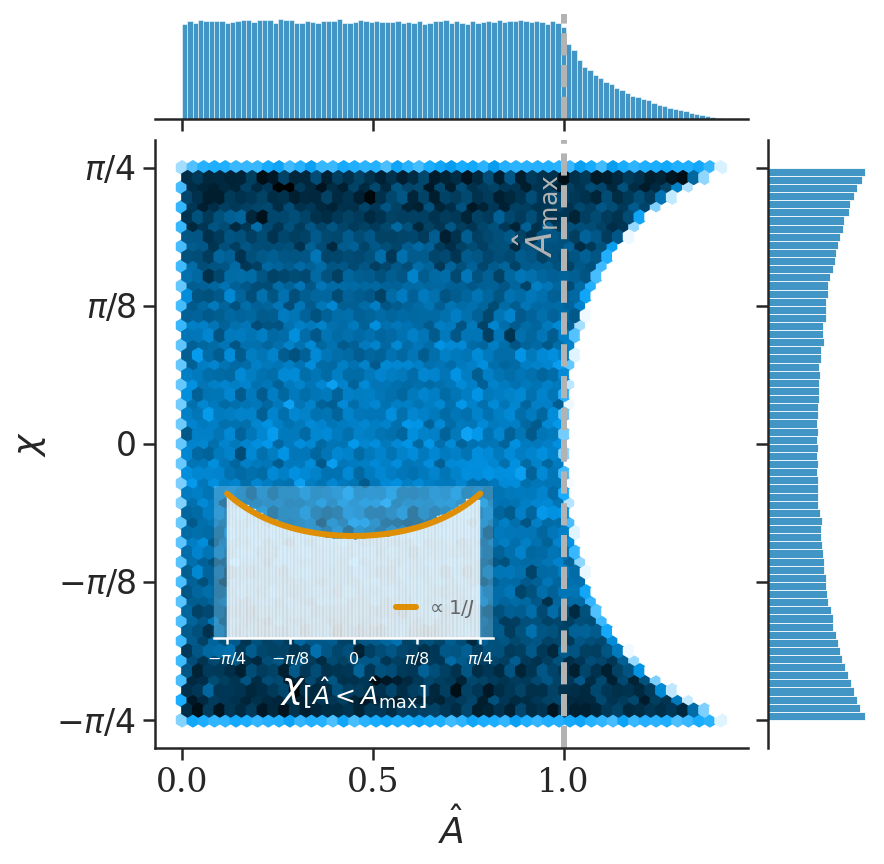

In [465]:
Nplot = -1
g = sns.jointplot(Ahat[:Nplot], chi[:Nplot], kind='hex')
g.ax_joint.set_xlabel(r'$\hat{A}$')
g.ax_joint.set_ylabel(r'$\chi$');

g.ax_joint.set_yticks([-np.pi/4, -np.pi/8, 0, np.pi/8, np.pi/4])
g.ax_joint.set_yticklabels([r'$-\pi/4$', r'$-\pi/8$', r'$0$', r'$\pi/8$',r'$\pi/4$']);

lkws = dict(c='0.7', ls='--', lw=3)
g.ax_joint.axvline(Ahatmax, **lkws);
g.ax_marg_x.axvline(Ahatmax, **lkws);

# g.ax_joint.tick_params(direction='in')

axins = g.ax_joint.inset_axes([0.1, 0.18, 0.47, 0.25])
axins.set_xticks(g.ax_joint.get_yticks())
axins.set_xticklabels(g.ax_joint.get_yticklabels())
axins.tick_params(labelsize=8, #direction='in', 
                  labelcolor='w', color='w', length=3)

sns.histplot(chi[Ahat<=Ahatmax], ax=axins, stat='density',
             color='w')

axins.plot(chis, inv_jac_Aep_to_Achi(chis),
           c=sns.color_palette()[1],
           label=r'$\propto 1/J$',
          lw=3)
axins.set_xlabel(r'$\chi_{[\hat{A} < \hat{A}_{\rm max}]}$', color='w')
axins.set_ylabel(None);
axins.set_yticks([]);
axins.patch.set_alpha(0.2);
for k in ['top', 'right', 'left']:
    axins.spines[k].set_visible(False)
axins.spines['bottom'].set_color('w')
axins.legend(fontsize=10, frameon=False, labelcolor='0.4', loc='lower right',
             handlelength=1, handletextpad=0.5);

g.ax_joint.annotate(r"$\hat{A}_\mathrm{max}$",
            xy=(Ahatmax, np.pi/4), xycoords='data', rotation=90,
            xytext=(-2, -3), textcoords='offset points',
            horizontalalignment='right', verticalalignment='top',
            color=lkws['c']);

## Circular polarizations

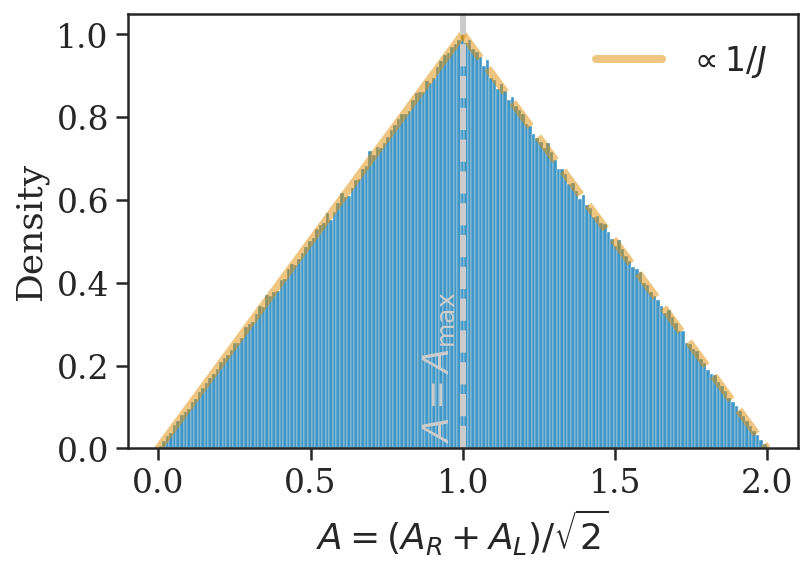

In [99]:
N = 1000000
Arlmax = np.sqrt(2)
Ar = rng.uniform(0, Arlmax, N)
Al = rng.uniform(0, Arlmax, N)
# phir = rng.uniform(0, 2*np.pi, N)
# phil = rng.uniform(0, 2*np.pi, N)
phir = rng.uniform(-np.pi, np.pi, N)
phil = rng.uniform(-np.pi, np.pi, N)

A = (Ar + Al)/np.sqrt(2)
e = (Ar - Al)/(Ar + Al)
phi = (phir + phil)/2
theta = (phil - phir)/2

sns.histplot(A, stat='density')

Amax = Arlmax / np.sqrt(2)
x = np.linspace(0, Amax, 100)

lkws = dict(lw=4, c=sns.color_palette()[1], alpha=0.5)
plt.plot(x, x, **lkws, label=r'$\propto 1/J$')
plt.plot(x+1, 1-x, ls='--', **lkws)

l = plt.axvline(Amax, lw=3, ls='--', c='0.8')
plt.gca().annotate(r"$A = A_\mathrm{max}$",
            xy=(Amax, 0), xycoords='data', rotation=90,
            xytext=(-3, 3), textcoords='offset points',
            horizontalalignment='right', verticalalignment='bottom',
            color=l.get_color());

plt.legend(frameon=False);
plt.xlabel(r'$A = \left(A_R + A_L\right)/\sqrt{2}$');
plt.savefig('jac_Aep_RL.pdf', bbox_inches='tight')

In [600]:
def inv_jac_Arl_to_Aep(A):
    j = A
    return j / trapz(j, A)

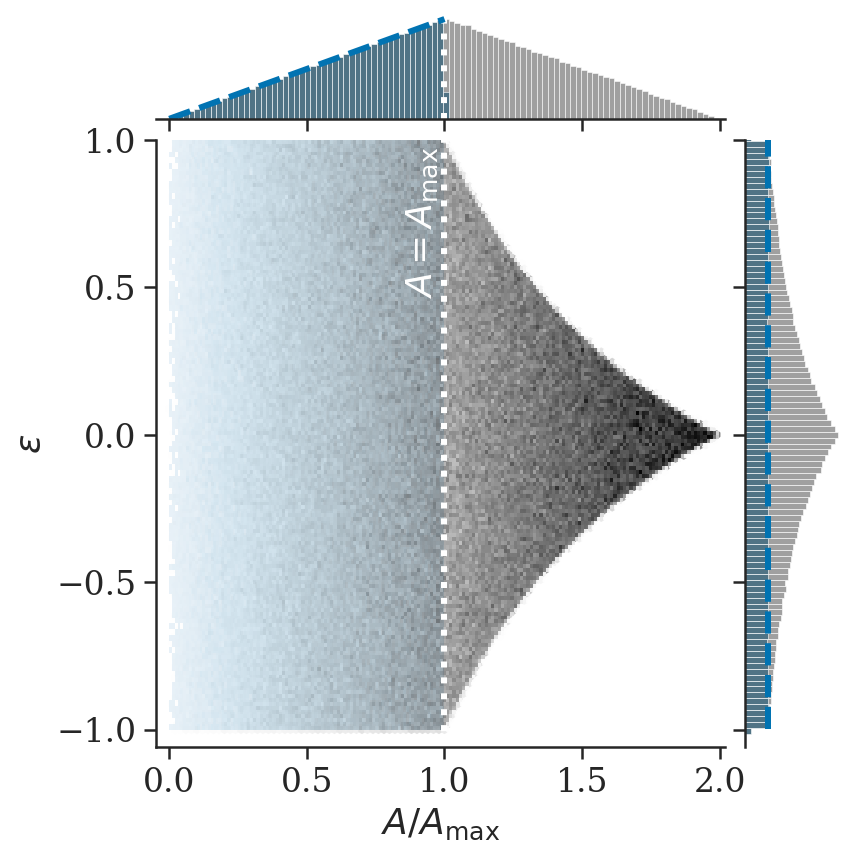

In [662]:
Nplot = np.inf

ix = rng.choice(len(A), min(Nplot, len(A)), replace=False)
x = A[ix]
y = e[ix]

xkdemax = max(A)*1.01
br = (-0.99*xkdemax, xkdemax)
c = sns.color_palette('colorblind', desat=0.4)[0]
marg_kws = dict(binrange=br, bins=200, stat='count')
joint_kws = dict(gridsize=64, extent=[0,2,-1,1], alpha=0.9)

g = sns.JointGrid(x=x, y=y, xlim=(-0.05, xkdemax), ylim=(-1.06,1))
# g.plot_joint(plt.hexbin, cmap='Greys', **joint_kws)
g.plot_joint(sns.histplot, cmap='Greys', alpha=0.9)
g.plot_marginals(sns.histplot, color='gray', **marg_kws)

g.x = g.x[x <= Amax]
g.y = g.y[x <= Amax]
g.plot_joint(sns.histplot, bins=100, color=c, alpha=0.25)
g.plot_marginals(sns.histplot, color=c, **marg_kws)

g.ax_joint.set_xlabel(r'$A/A_{\rm max}$')
g.ax_joint.set_ylabel(r'$\epsilon$');
g.ax_joint.set_yticks([-1, -0.5, 0, 0.5, 1])
# g.ax_joint.plot([],[], label='full', c='gray')
# g.ax_joint.plot([],[], label='restricted', c=c)
# g.ax_joint.legend(framealpha=0.5);

lkws = dict(c='w', ls=':', lw=3)
g.ax_joint.axvline(Amax, **lkws);
g.ax_marg_x.axvline(Amax, **lkws);

cjac = sns.color_palette()[0]
jac_kws = dict(c=cjac, ls='--', lw=3)
As = np.linspace(0, 1, 100)

nbins = marg_kws['bins'] * Amax / (0.99*xkdemax)
c = 2*len(g.x) / nbins
g.ax_marg_x.plot(As, inv_jac_Arl_to_Aep(As)*c, **jac_kws)

sns.histplot(e[A<=Amax], ax=axins, stat='density', color='w', alpha=0.5)

es = np.linspace(-0.999, 0.999, 100)
g.ax_marg_y.plot(np.ones(len(es))*c/2, es, **jac_kws)

g.ax_joint.annotate(r"$A=A_\mathrm{max}$",
            xy=(Amax, 1), xycoords='data', rotation=90,
            xytext=(-2, -3), textcoords='offset points',
            horizontalalignment='right', verticalalignment='top',
            color=lkws['c']);
plt.savefig("jac_Aeps_Arl.pdf", bbox_inches='tight')

Let's look at the angle transformations.

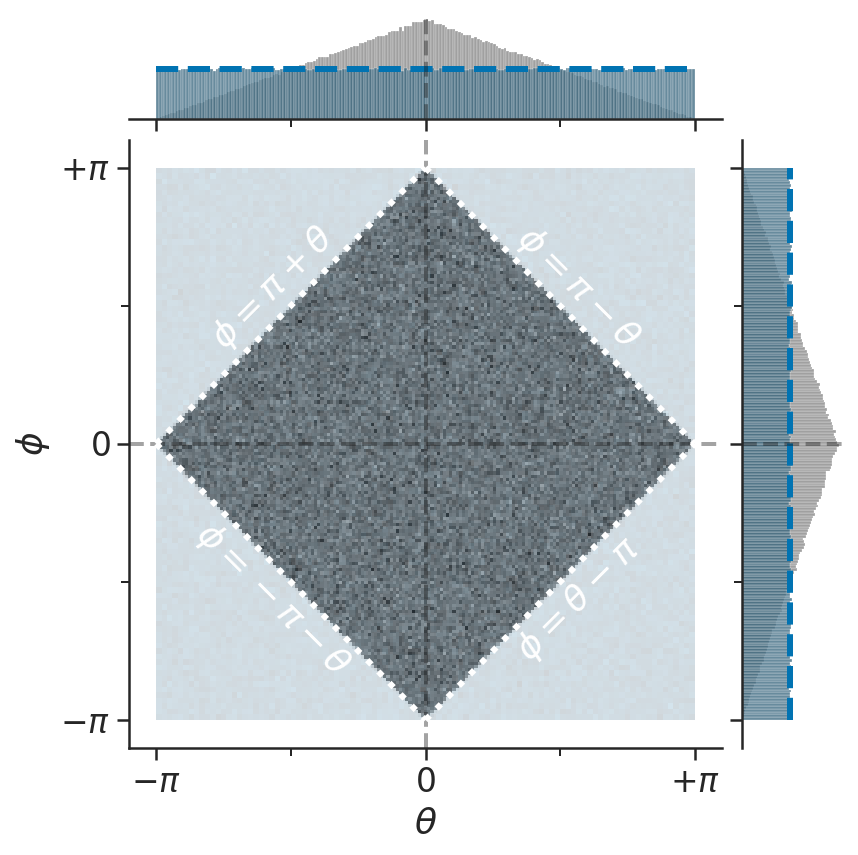

In [141]:
Nplot = np.inf

ix = rng.choice(len(A), min(Nplot, len(A)), replace=False)
x = theta[ix]
y = phi[ix]

# xkdemax = max(A)*1.01
# br = (-0.99*xkdemax, xkdemax)
c = sns.color_palette('colorblind', desat=0.4)[0]
marg_kws = dict(stat='count', bins=200)
joint_kws = dict(gridsize=64, extent=[0,2,-1,1], alpha=0.9)

g = sns.JointGrid(x=x, y=y)
# g.plot_joint(plt.hexbin, cmap='Greys', **joint_kws)
g.plot_joint(sns.histplot, cmap='Greys', alpha=0.9)
g.plot_marginals(sns.histplot, color='gray', **marg_kws)

a = rng.choice(2, len(g.x))
bx = rng.choice([-np.pi, np.pi], len(g.x))
by = rng.choice([-np.pi, np.pi], len(g.x))

g.x = (g.x + np.pi + a*bx) % (2*np.pi) - np.pi
g.y = (g.y + np.pi + a*by) % (2*np.pi) - np.pi
g.plot_joint(sns.histplot, bins=100, color=c, alpha=0.25)
g.plot_marginals(sns.histplot, color=c, **marg_kws)

# auxiliary lines

jac_kws = dict(c=cjac, ls='--', lw=3)
angles = np.linspace(-np.pi, np.pi, 100)
jac = np.ones(len(angles))*len(g.x)/marg_kws['bins']
g.ax_marg_x.plot(angles,jac , **jac_kws)
g.ax_marg_y.plot(jac, angles, **jac_kws)


lkws = dict(ls='--', lw=2, c='k', alpha=0.4)
for ax in[g.ax_joint, g.ax_marg_x]:
    ax.axvline(0, **lkws)
for ax in[g.ax_joint, g.ax_marg_y]:
    ax.axhline(0, **lkws)

ax = g.ax_joint
ths = np.linspace(0, np.pi, 100)
ax.plot(ths, np.pi-ths, ls=':', lw=3, c='w', zorder=100)
ax.plot(ths, ths-np.pi, ls=':', lw=3, c='w', zorder=100)
ths = np.linspace(-np.pi, 0, 100)
ax.plot(ths, np.pi+ths, ls=':', lw=3, c='w', zorder=100)
ax.plot(ths, -ths-np.pi, ls=':', lw=3, c='w', zorder=100)

g.ax_joint.set_xlabel(r'$\theta$')
g.ax_joint.set_ylabel(r'$\phi$');

g.ax_joint.set_xticks([-np.pi, 0, np.pi], [r'$-\pi$', r'$0$', r'$+\pi$'])
g.ax_joint.set_xticks([-np.pi/2, np.pi/2], minor=True);
g.ax_joint.set_yticks([-np.pi, 0, np.pi], [r'$-\pi$', r'$0$', r'$+\pi$']);
g.ax_joint.set_yticks([-np.pi/2, np.pi/2], minor=True);

g.ax_joint.annotate(r"$\phi = \pi - \theta$",
            xy=(np.pi/2,np.pi/2), xycoords='data', rotation=-45,
            xytext=(9, 9), textcoords='offset points',
            horizontalalignment='center', verticalalignment='center',
            color='w');

g.ax_joint.annotate(r"$\phi = \theta - \pi$",
            xy=(np.pi/2, -np.pi/2), xycoords='data', rotation=45,
            xytext=(9, -9), textcoords='offset points',
            horizontalalignment='center', verticalalignment='center',
            color='w');

g.ax_joint.annotate(r"$\phi = \pi + \theta$",
            xy=(-np.pi/2, np.pi/2), xycoords='data', rotation=45,
            xytext=(-9, 9), textcoords='offset points',
            horizontalalignment='center', verticalalignment='center',
            color='w');

g.ax_joint.annotate(r"$\phi = -\pi - \theta$",
            xy=(-np.pi/2, -np.pi/2), xycoords='data', rotation=-45,
            xytext=(-9, -9), textcoords='offset points',
            horizontalalignment='center', verticalalignment='center',
            color='w');

plt.savefig("jac_Aeps_Arl_angles.pdf", bbox_inches='tight')

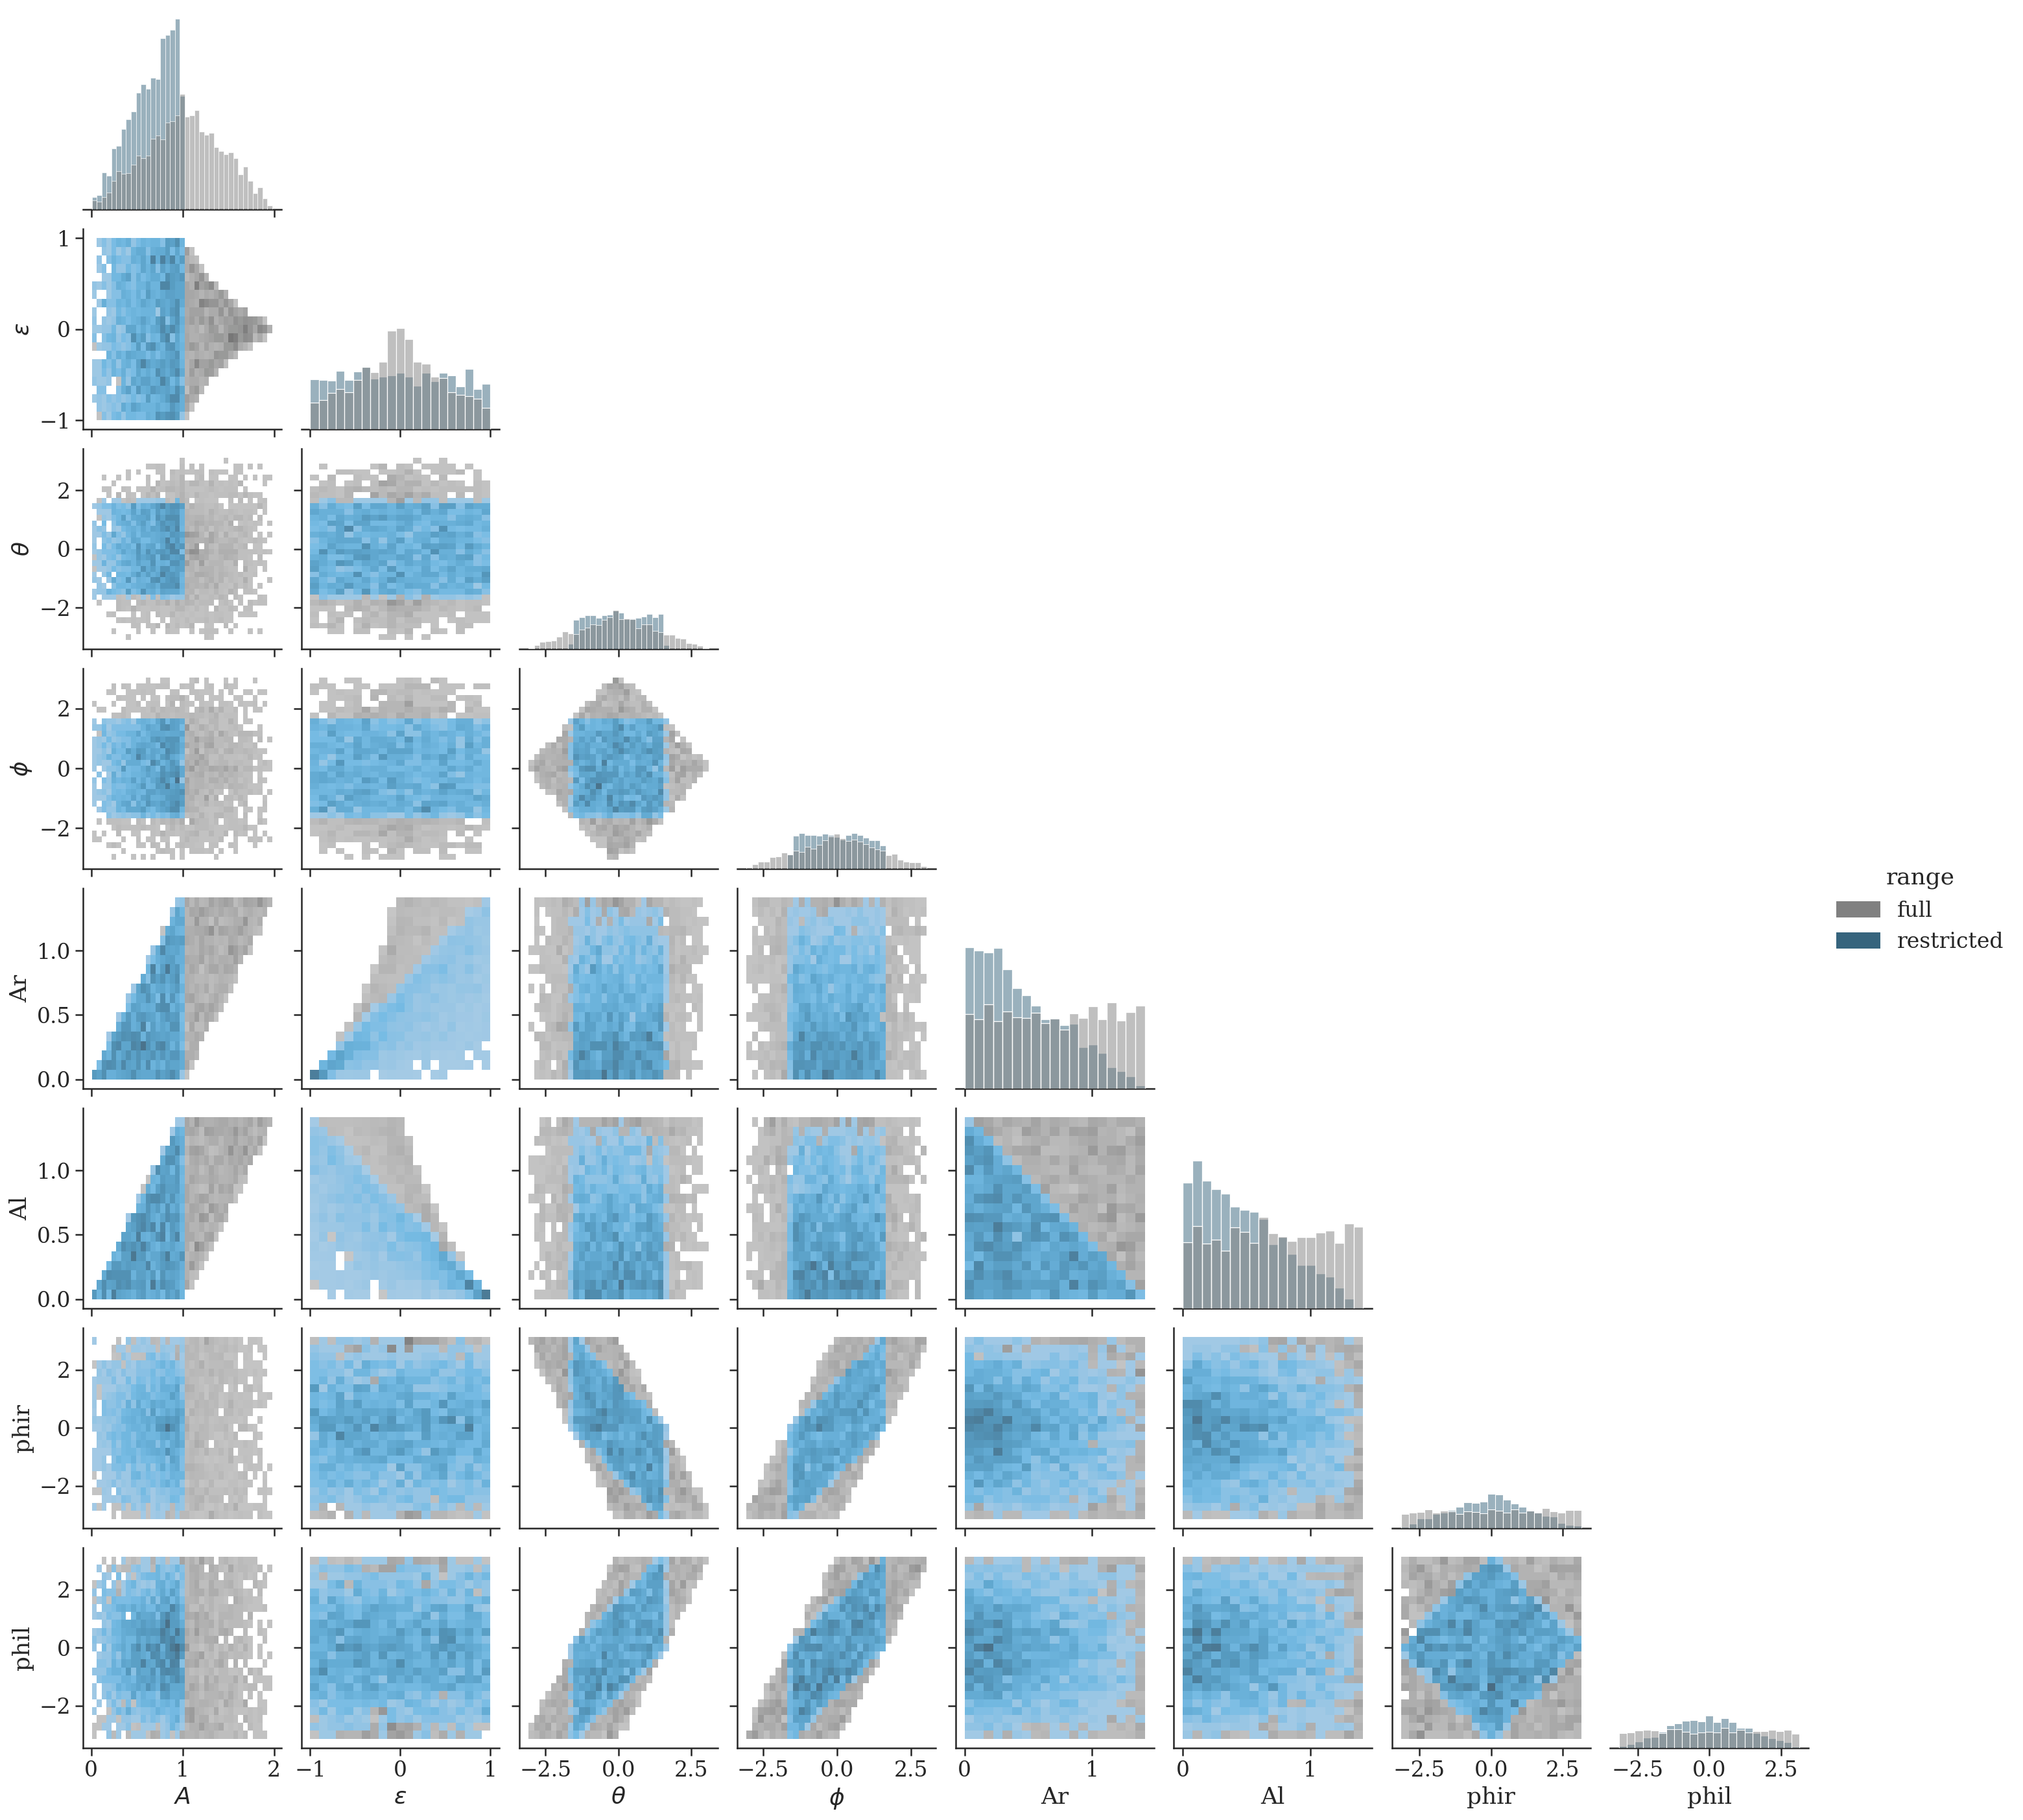

In [664]:
Nplot = 10000

ix = rng.choice(len(A), min(Nplot, len(A)), replace=False)
df = pd.DataFrame({'$A$': A[ix], r'$\epsilon$': e[ix], r'$\theta$': theta[ix], r'$\phi$': phi[ix],
                   'Ar': Ar[ix], 'Al': Al[ix], 'phir': phir[ix], 'phil': phil[ix]})
df2 = df[(df['$A$']< Amax) & (np.abs(df[r'$\theta$'])< np.pi/2)& (np.abs(df[r'$\phi$'])< np.pi/2)].copy()

df = df.iloc[:len(df2)]
df['range'] = 'full'
df2['range'] = 'restricted'
df = df.append(df2, ignore_index=True)

p = sns.color_palette(['gray', sns.color_palette('colorblind', desat=0.4)[0]])
sns.set(context='notebook', palette=p, style='ticks',
        font='serif', font_scale=1.5)

ks = ['$A$', r'$\epsilon$', 'range']
sns.pairplot(df, kind='hist', corner=True, hue='range', diag_kws=dict(stat='frequency'))

sns.set(context='notebook', palette='colorblind', style='ticks',
        font='serif', font_scale=1.5)

### Alternative shape parameter

Look at the $\hat{A},\chi$ parametrization.

In [665]:
def inv_jac_Arl_to_Achi(Ahat):
    j = (Ahat*2)
    return j / trapz(j, Ahat)

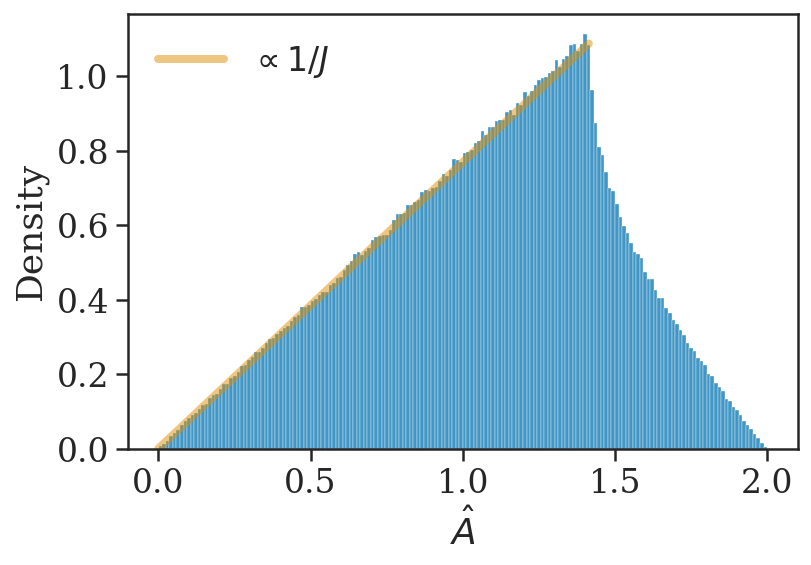

In [666]:
Ahat = np.sqrt(Ar**2 + Al**2)
chi = np.arctan((Ar - Al)/(Ar + Al))

sns.histplot(Ahat, stat='density')

Amax = Arlmax
x = np.linspace(0, Amax, 100)

lkws = dict(lw=4, c=sns.color_palette()[1], alpha=0.5)
plt.plot(x, inv_jac_Arl_to_Achi(x)/1.3, **lkws, label=r'$\propto 1/J$')
# plt.plot(x+1, 1-x, ls='--', **lkws)

# l = plt.axvline(Amax, lw=3, ls='--', c='0.8')
# plt.gca().annotate(r"$A = A_\mathrm{max}$",
#             xy=(Amax, 0), xycoords='data', rotation=90,
#             xytext=(-3, 3), textcoords='offset points',
#             horizontalalignment='right', verticalalignment='bottom',
#             color=l.get_color());

plt.legend(frameon=False);
plt.xlabel(r'$\hat{A}$');
plt.savefig('jac_Achi_RL.pdf', bbox_inches='tight')

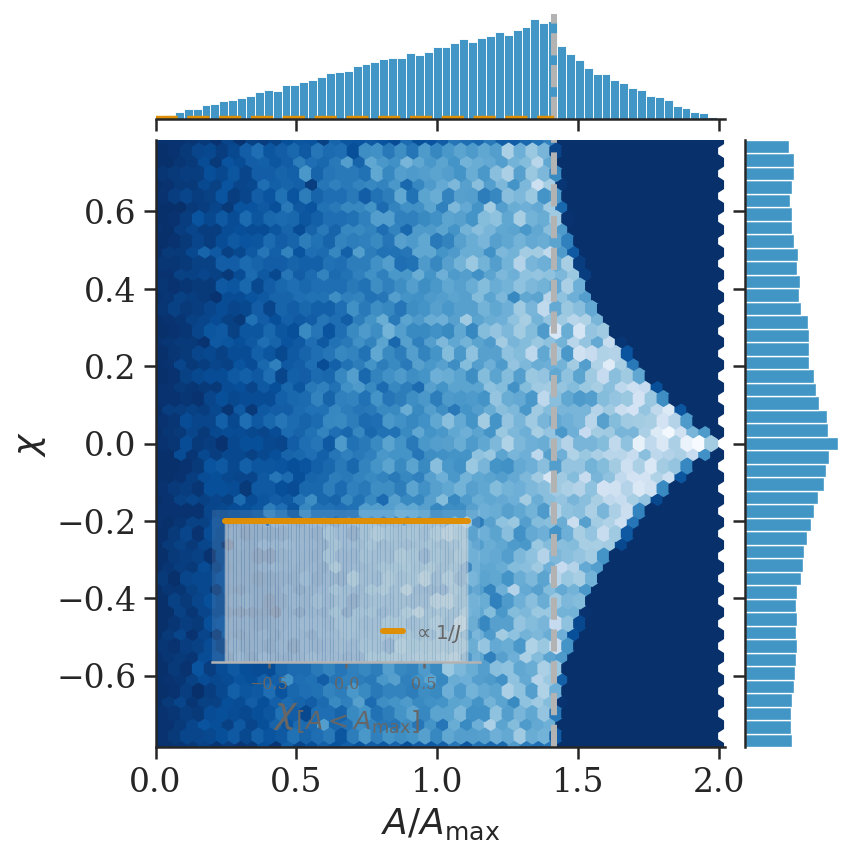

In [ ]:
Nplot = 50000

ix = rng.choice(len(Ahat), min(Nplot, len(A)), replace=False)
x = Ahat[ix]
y = chi[ix]

g = sns.jointplot(x=x, y=y, xlim=(0, max(A)*1.01), ylim=(-np.pi/4, np.pi/4), kind='hex',
                  joint_kws=dict(cmap='Blues_r'))

g.ax_joint.set_xlabel(r'$A/A_{\rm max}$')
g.ax_joint.set_ylabel(r'$\chi$');

# g.ax_joint.set_yticks([-1, -0.5, 0, 0.5, 1])

lkws = dict(c='0.7', ls='--', lw=3)
g.ax_joint.axvline(Amax, **lkws);
g.ax_marg_x.axvline(Amax, **lkws);

# g.ax_joint.tick_params(direction='in')

As = np.linspace(0, Amax, 100)
## get jacobian norm
g.ax_marg_x.plot(As, inv_jac_Arl_to_Achi(As)/np.sqrt(2),
           c=sns.color_palette()[1],
          lw=3, ls='--')

axins = g.ax_joint.inset_axes([0.1, 0.14, 0.47, 0.25])
axins.tick_params(labelsize=8, labelcolor='0.4', color='0.4', length=3)

sns.histplot(chi[Ahat<=Amax], ax=axins, stat='density',
             color='0.8', alpha=0.5)

chis = np.linspace(-np.pi/4, np.pi/4, 100)
axins.plot(chis, np.ones(len(chis))/(np.pi/2),
           c=sns.color_palette()[1],
           label=r'$\propto 1/J$',
          lw=3)
axins.set_xlabel(r'$\chi_{[A < A_{\rm max}]}$', color='0.4')
axins.set_ylabel(None);
axins.set_yticks([]);
axins.patch.set_alpha(0.1);
for k in ['top', 'right', 'left']:
    axins.spines[k].set_visible(False)
axins.spines['bottom'].set_color('0.7')
axins.legend(fontsize=10, frameon=False, labelcolor='0.4', loc='lower right',
             handlelength=1, handletextpad=0.5);


g.ax_joint.annotate(r"$A=A_\mathrm{max}$",
            xy=(Amax, 1), xycoords='data', rotation=90,
            xytext=(-2, -3), textcoords='offset points',
            horizontalalignment='right', verticalalignment='top',
            color=lkws['c']);
# plt.savefig("jac_Achi_Arl.pdf", bbox_inches='tight')

## Linear polarizations

In [13]:
def inv_jac_Apc_to_Aep(A, e, theta, normalize=True):
    cos2th2 = np.cos(2*theta)**2
    j = (2*A)/np.sqrt((1 + e**2)**2/(1 - e**2)**2 - cos2th2)
    if normalize:
        return j / trapz(j, A)
    else:
        return j

def jac_A_ApAc(A):
    j = (2.*A)
    return j / trapz(j, A)

In [55]:
N = 1000000

rng = np.random.default_rng(12345)

Apcmax = 1
Amax = Apcmax

Ap = rng.uniform(0, Apcmax, N)
Ac = rng.uniform(0, Apcmax, N)
phip = rng.uniform(0, 2*np.pi, N)
phic = rng.uniform(0, 2*np.pi, N)
# phip = arcsin(random.uniform(-1, 1, N))
# phic = arcsin(random.uniform(-1, 1, N))

Ar = np.sqrt(Ap**2 + Ac**2 + 2*Ap*Ac*np.sin(phic - phip))/np.sqrt(2)
Al = np.sqrt(Ap**2 + Ac**2 - 2*Ap*Ac*np.sin(phic - phip))/np.sqrt(2)

xp = Ap*np.cos(phip)
yp = Ap*np.sin(phip)
xc = Ac*np.cos(phic)
yc = Ac*np.sin(phic)

phir = np.arctan2(yp - xc, xp + yc)# + np.pi
phil = np.arctan2(yp + xc, xp - yc)# + np.pi

A = (Ar + Al)/np.sqrt(2)
e = (Ar - Al)/(Ar + Al)
theta = (phil - phir)/2
phi = (phil + phir)/2

Ahat = A*np.sqrt(1+e**2)
chi = np.arctan(e)

In [56]:
# Nplot = np.inf

# ix = rng.choice(len(A), min(Nplot, len(A)), replace=False)
# x = A[ix]
# y = e[ix]

# g = sns.jointplot(x=x, y=y, xlim=(0, max(A)*1.01), ylim=(-1,1), 
#                   kind='hex', joint_kws=dict(cmap='Blues_r'),
#                   marginal_kws=dict(stat='density')
#                  )

# g.ax_joint.set_xlabel(r'$A/A_{\rm max}$')
# g.ax_joint.set_ylabel(r'$\epsilon$');

# g.ax_joint.set_yticks([-1, -0.5, 0, 0.5, 1])

# lkws = dict(c='0.7', ls='--', lw=3)
# g.ax_joint.axvline(Amax, **lkws);
# g.ax_marg_x.axvline(Amax, **lkws);

# # g.ax_joint.tick_params(direction='in')

# As = np.linspace(0, Amax, 100)
# f = ss.gaussian_kde(A)
# g.ax_marg_x.plot(As[As<=Amax], inv_jac_Apc_to_Aep(As[As<=Amax], 0.5, 0)*max(f(As))/2,
#            c=sns.color_palette()[1],
#           lw=3, ls='--')

# cins = '0.8'
# axins = g.ax_joint.inset_axes([0.1, 0.14, 0.47, 0.25])
# axins.tick_params(labelsize=8, labelcolor=cins, color=cins, length=3)

# sns.histplot(e[A<=Amax], ax=axins, stat='density',
#              color='0.8', alpha=0.5)

# axins.set_xlabel(r'$\epsilon_{[A < A_{\rm max}]}$', color=cins)
# axins.set_ylabel(None);
# axins.set_yticks([]);
# axins.patch.set_alpha(0.1);
# for k in ['top', 'right', 'left']:
#     axins.spines[k].set_visible(False)
# axins.spines['bottom'].set_color('0.7')
# # axins.legend(fontsize=10, frameon=False, labelcolor=cins, loc='lower right',
# #              handlelength=1, handletextpad=0.5);


# g.ax_joint.annotate(r"$A=A_\mathrm{max}$",
#             xy=(Amax, 1), xycoords='data', rotation=90,
#             xytext=(-2, -3), textcoords='offset points',
#             horizontalalignment='right', verticalalignment='top',
#             color=lkws['c']);
# # plt.savefig("jac_Aeps_Apc.pdf", bbox_inches='tight')

In [ ]:
len(df2)/len(df)/10, 1/(2*np.pi)

(0.05, 0.15915494309189535)

In [84]:
def my_hist(x, label, color, **kws):
    ax0 = plt.gca()
    ax = ax0.twinx()
    
    sns.despine(ax=ax, left=True, top=True, right=False)
    ax.yaxis.tick_right()
    ax.set_ylabel('Counts')
    
    print(kws)
    sns.histplot(x, label=label, color=color, ax=ax, kde=True, **kws)

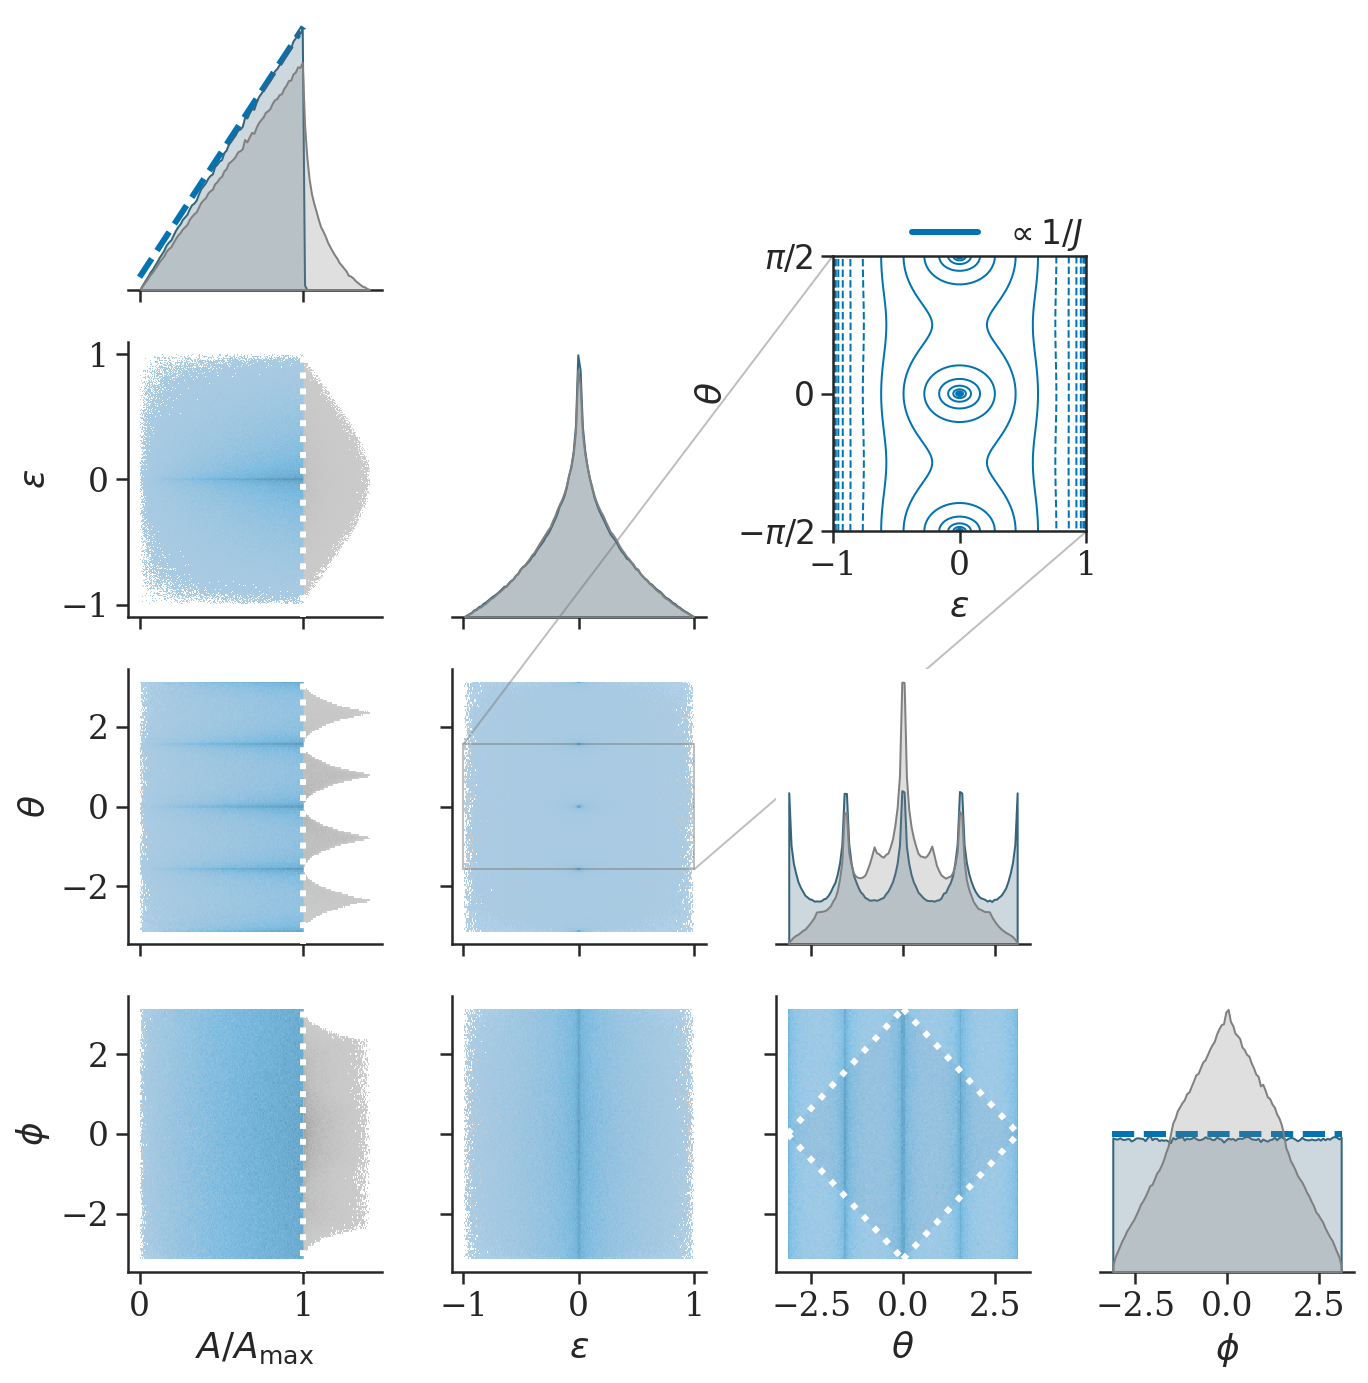

In [98]:
Nplot = np.inf
ix = rng.choice(len(A), min(Nplot, len(A)), replace=False)

cjac = sns.color_palette()[0]

Akey = r'$A/A_{\rm max}$'
df = pd.DataFrame({Akey: A[ix], r'$\epsilon$': e[ix], r'$\theta$': theta[ix], r'$\phi$': phi[ix],
                   'Ap': Ap[ix], 'Ac': Ac[ix], 'phip': phip[ix], 'phic': phic[ix]})
# df2 = df[(df[Akey]< Amax) & (np.abs(df[r'$\theta$'])< np.pi/2)& (np.abs(df[r'$\phi$'])< np.pi/2)].copy()
df2 = df[(df[Akey]< Amax)].copy()

y = rng.choice([0, 1], len(df2))
for k in [r'$\theta$', r'$\phi$']:
    x = y*rng.choice([-1, 1], len(df2))
    df2[k] = ((df2[k] + np.pi + x*np.pi) % (2*np.pi)) - np.pi

df = df.iloc[:len(df2)]
df['range'] = 'full'
df2['range'] = 'restricted'
df = df.append(df2, ignore_index=True)

p = sns.color_palette(['gray', sns.color_palette('colorblind', desat=0.4)[0]])
sns.set(context='notebook', palette=p, style='ticks', font='serif', font_scale=1.5)

ks = [Akey, r'$\epsilon$', r'$\theta$', r'$\phi$', 'range']
# sns.pairplot(df[ks], kind='hist', corner=True, hue='range', diag_kws=dict(stat='count'))

Akws = dict(bins=100, binrange=(0, max(A)))
phikws = dict(bins=100, binrange=(-np.pi, np.pi))
g = sns.PairGrid(data=df[ks], hue='range', diag_sharey=False, corner=True, 
                 hue_kws={Akey: Akws, r'$\phi$': phikws})
g.map_lower(sns.histplot, alpha=0.9, rasterized=True)
g.map_diag(sns.histplot, stat='density', bins=100, element='poly')
# g.map_diag(my_hist, stat='density', bins=100, element='poly', common_norm=True)

## plot Jacobians
As = np.linspace(0, Amax, 100)
nbins = Akws['bins'] * Amax / Akws['binrange'][1]
c = 2*len(df2[Akey]) / nbins
g.axes[0,0].plot(As[As<=Amax], inv_jac_Apc_to_Aep(As[As<=Amax]*c/10000, 0.5, 0),
                 c=cjac, lw=3, ls='--')

for ax in g.axes[:,0]:
    ax.axvline(Amax, ls=':', lw=3, c='w', zorder=100)

phis = np.linspace(-np.pi, np.pi, 100)
yl = g.axes[-1,0].get_ylim()
g.axes[-1,-1].plot(phis, np.ones(len(phis))*len(df2)/len(df)/100, c=cjac, lw=3, ls='--')
# g.axes[-1,-1].plot(phis, np.ones(len(phis))*(2*np.pi), c=cjac, lw=3, ls='--')
for ax in g.axes[-1,:-1]:
    ax.set_ylim(yl)

ax = g.axes[-1,2]
ths = np.linspace(0, np.pi, 100)
ax.plot(ths, np.pi-ths, ls=':', lw=3, c='w', zorder=100)
ax.plot(ths, ths-np.pi, ls=':', lw=3, c='w', zorder=100)
ths = np.linspace(-np.pi, 0, 100)
ax.plot(ths, np.pi+ths, ls=':', lw=3, c='w', zorder=100)
ax.plot(ths, -ths-np.pi, ls=':', lw=3, c='w', zorder=100)

ax = g.axes[2,1]
axins = ax.inset_axes([1.5, 1.5, 1, 1])

# sub region of the original plot
x1, x2, y1, y2 = -1, 1, -np.pi/2, np.pi/2

es = np.linspace(-0.999, 0.999, 2048)
th = np.linspace(y1, y2, len(es))
XS, YS = np.meshgrid(es, th, indexing='ij')
ZS = inv_jac_Apc_to_Aep(1, XS, YS, normalize=False)
# axins.contourf(XS, YS, np.log(ZS), levels=64, cmap='Blues')
axins.contour(XS, YS, np.log(ZS), levels=24, colors=[cjac], linewidths=1)

axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_yticks([-np.pi/2, 0, np.pi/2])
axins.set_yticklabels([r'$-\pi/2$', '$0$', r'$\pi/2$'])
axins.set_ylabel(r'$\theta$')
axins.set_xlabel(r'$\epsilon$')

axins.plot([], [], c=cjac, lw=3, label=r"$\propto 1/J$")
axins.legend(loc='upper center', bbox_to_anchor=(0.65, 1.25),
            frameon=False)

ax.indicate_inset_zoom(axins, edgecolor="gray")

sns.set(context='notebook', palette='colorblind', style='ticks',
        font='serif', font_scale=1.5)

plt.savefig("jac_Aeps_Apc_corner.pdf", bbox_inches='tight')

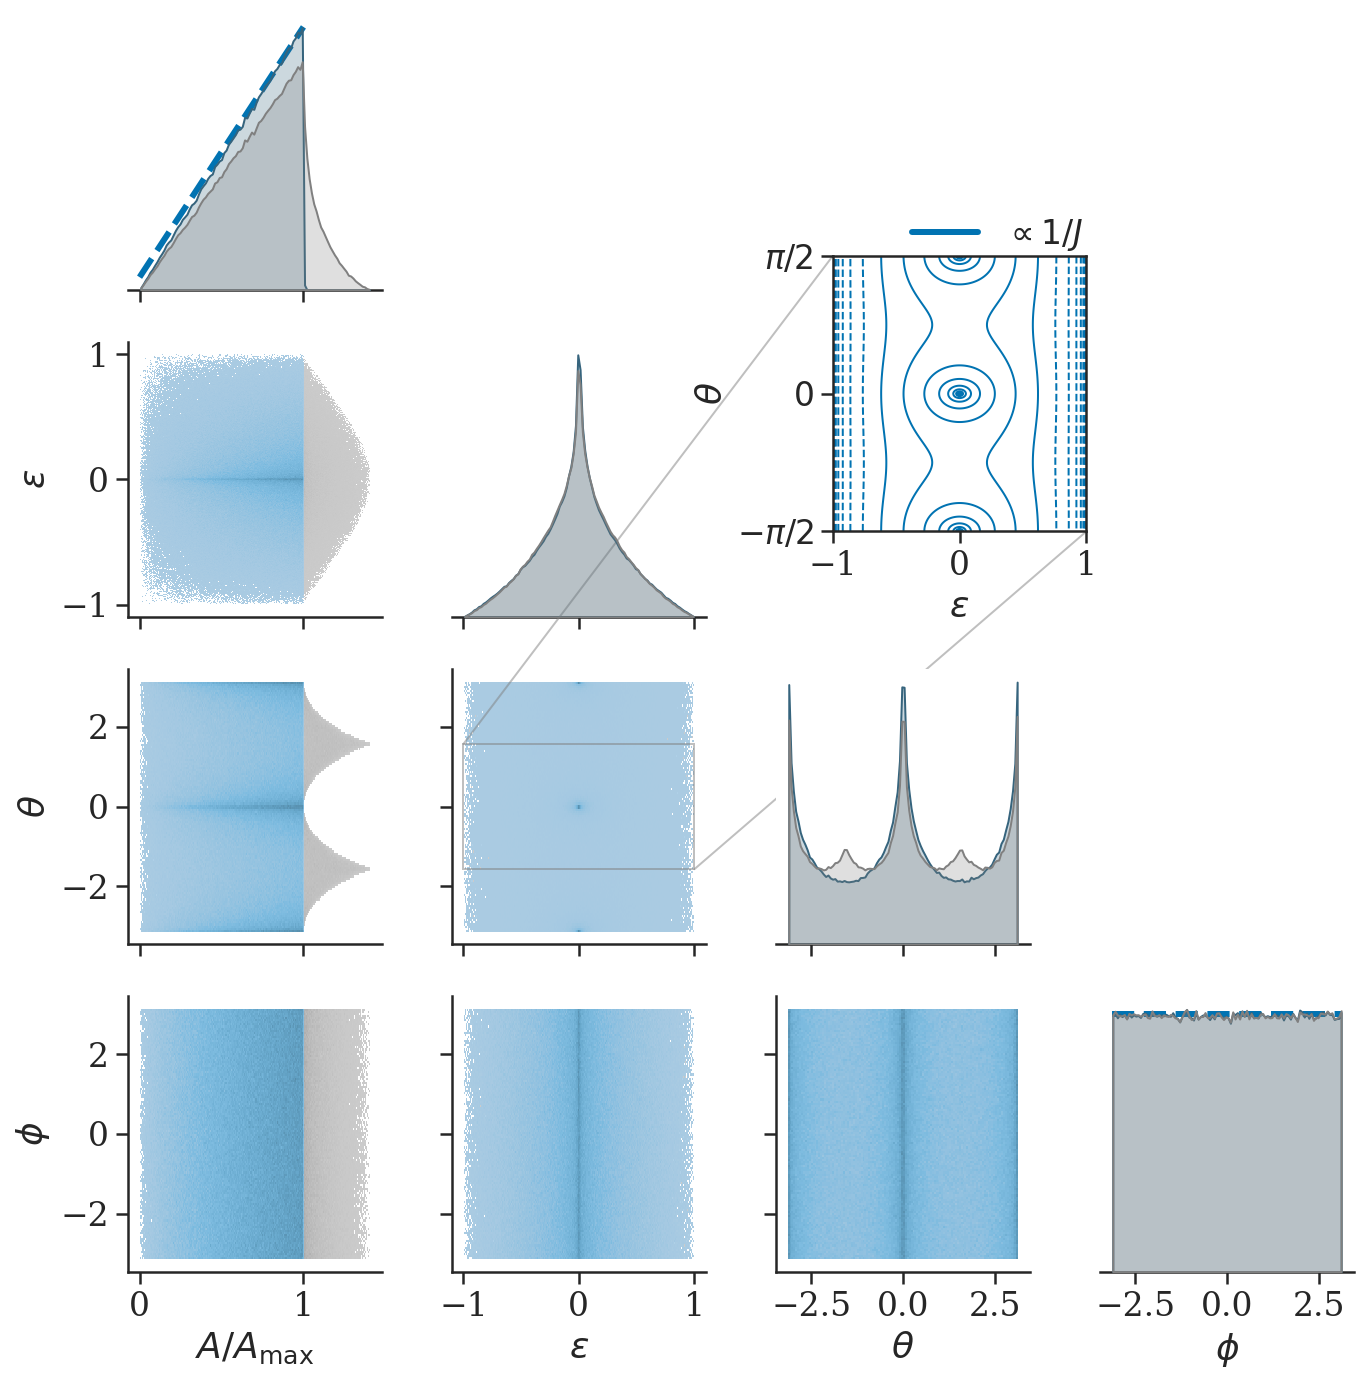

In [878]:
Nplot = np.inf

ix = rng.choice(len(A), min(Nplot, len(A)), replace=False)
Akey = r'$A/A_{\rm max}$'
def get_angle(x):
#     return x
    return np.sign(x)*(x % np.pi/2)
df = pd.DataFrame({Akey: A[ix], r'$\epsilon$': e[ix], r'$\theta$': 2*theta[ix] % (2*np.pi) - np.pi, r'$\phi$': 2*phi[ix] % (2*np.pi) - np.pi,
                   'Ap': Ap[ix], 'Ac': Ac[ix], 'phip': phip[ix], 'phic': phic[ix]})
df2 = df[(df[Akey]< Amax)].copy()# & (np.abs(df[r'$\theta$'])< np.pi/2)& (np.abs(df[r'$\phi$'])< np.pi/2)].copy()
# for k in [r'$\theta$', r'$\phi$']:
#     x = df2[k]
#     df2[k][abs(x) > np.pi/2] = df2[k][abs(x) > np.pi/2] - np.sign(x)*np.pi

df = df.iloc[:len(df2)]
df['range'] = 'full'
df2['range'] = 'restricted'
df = df.append(df2, ignore_index=True)

p = sns.color_palette(['gray', sns.color_palette('colorblind', desat=0.4)[0]])
sns.set(context='notebook', palette=p, style='ticks', font='serif', font_scale=1.5)

ks = [Akey, r'$\epsilon$', r'$\theta$', r'$\phi$', 'range']
# sns.pairplot(df[ks], kind='hist', corner=True, hue='range', diag_kws=dict(stat='count'))

Akws = dict(bins=100, binrange=(0, max(A)))
phikws = dict(bins=100, binrange=(-np.pi/2, np.pi/2))
g = sns.PairGrid(data=df[ks], hue='range', diag_sharey=False, corner=True, 
                 hue_kws={Akey: Akws, r'$\phi$': phikws})
g.map_lower(sns.histplot, alpha=0.9, rasterized=True)
g.map_diag(sns.histplot, stat='count', bins=100, element='poly')

## plot Jacobians
As = np.linspace(0, Amax, 100)
nbins = Akws['bins'] * Amax / Akws['binrange'][1]
c = 2*len(df2[Akey]) / nbins
g.axes[0,0].plot(As[As<=Amax], inv_jac_Apc_to_Aep(As[As<=Amax]*c/10000, 0.5, 0),
                 c=cjac, lw=3, ls='--')

phis = np.linspace(-np.pi, np.pi, 100)
yl = g.axes[-1,0].get_ylim()
g.axes[-1,-1].plot(phis, np.ones(len(phis))*6*len(df2)/len(df), c=cjac, lw=3, ls='--')
for ax in g.axes[-1,:-1]:
    ax.set_ylim(yl)

ax = g.axes[2,1]
axins = ax.inset_axes([1.5, 1.5, 1, 1])

# sub region of the original plot
x1, x2, y1, y2 = -1, 1, -np.pi/2, np.pi/2

es = np.linspace(-0.999, 0.999, 2048)
th = np.linspace(y1, y2, len(es))
XS, YS = np.meshgrid(es, th, indexing='ij')
ZS = inv_jac_Apc_to_Aep(1, XS, YS, normalize=False)
# axins.contourf(XS, YS, np.log(ZS), levels=64, cmap='Blues')
axins.contour(XS, YS, np.log(ZS), levels=24, colors=[cjac], linewidths=1)

axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_yticks([-np.pi/2, 0, np.pi/2])
axins.set_yticklabels([r'$-\pi/2$', '$0$', r'$\pi/2$'])
axins.set_ylabel(r'$\theta$')
axins.set_xlabel(r'$\epsilon$')

axins.plot([], [], c=cjac, lw=3, label=r"$\propto 1/J$")
axins.legend(loc='upper center', bbox_to_anchor=(0.65, 1.25),
            frameon=False)

ax.indicate_inset_zoom(axins, edgecolor="gray")

sns.set(context='notebook', palette='colorblind', style='ticks',
        font='serif', font_scale=1.5)

# plt.savefig("jac_Aeps_Apc_corner.pdf", bbox_inches='tight')

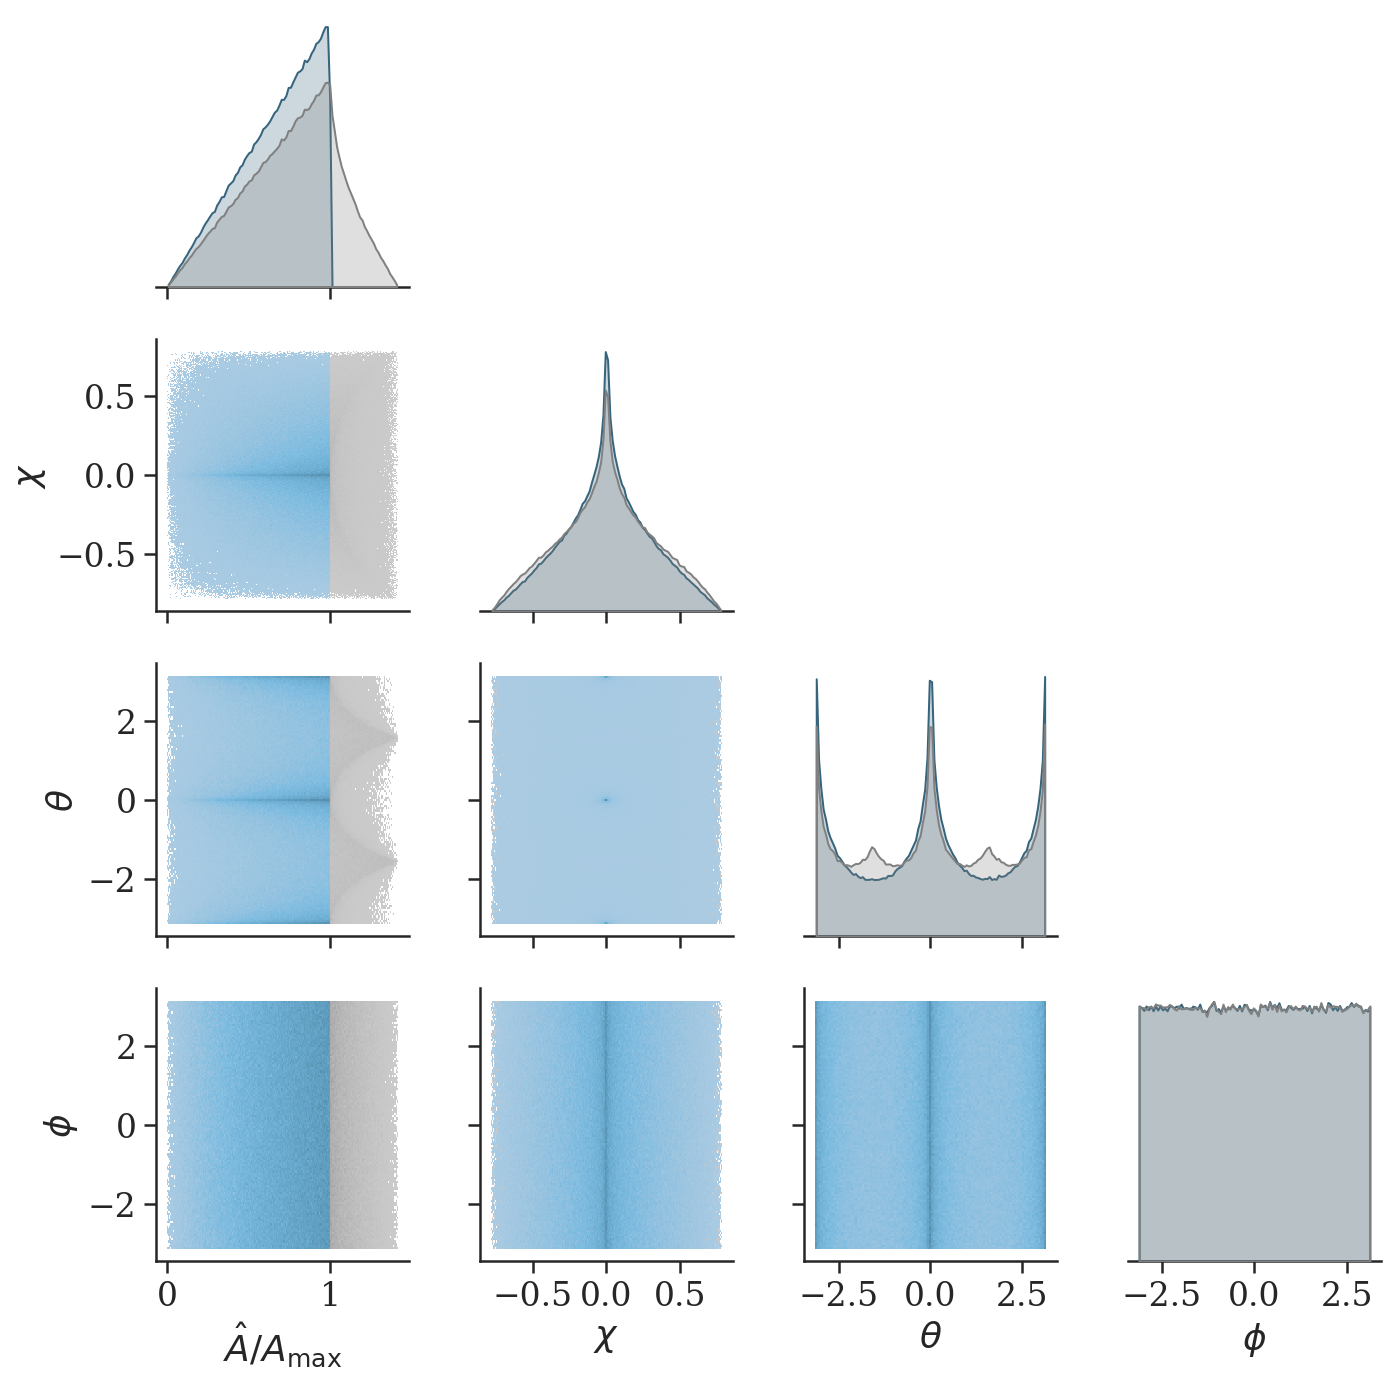

In [883]:
Nplot = np.inf

ix = rng.choice(len(A), min(Nplot, len(A)), replace=False)
Akey = r'$\hat{A}/A_{\rm max}$'
def get_angle(x):
#     return x
    return np.sign(x)*(x % np.pi/2)
df = pd.DataFrame({Akey: Ahat[ix], r'$\chi$': chi[ix], r'$\theta$': 2*theta[ix] % (2*np.pi) - np.pi, r'$\phi$': 2*phi[ix] % (2*np.pi) - np.pi,
                   'Ap': Ap[ix], 'Ac': Ac[ix], 'phip': phip[ix], 'phic': phic[ix]})
df2 = df[(df[Akey]< Amax)].copy()# & (np.abs(df[r'$\theta$'])< np.pi/2)& (np.abs(df[r'$\phi$'])< np.pi/2)].copy()
# for k in [r'$\theta$', r'$\phi$']:
#     x = df2[k]
#     df2[k][abs(x) > np.pi/2] = df2[k][abs(x) > np.pi/2] - np.sign(x)*np.pi

df = df.iloc[:len(df2)]
df['range'] = 'full'
df2['range'] = 'restricted'
df = df.append(df2, ignore_index=True)

p = sns.color_palette(['gray', sns.color_palette('colorblind', desat=0.4)[0]])
sns.set(context='notebook', palette=p, style='ticks', font='serif', font_scale=1.5)

ks = [Akey, r'$\chi$', r'$\theta$', r'$\phi$', 'range']
# sns.pairplot(df[ks], kind='hist', corner=True, hue='range', diag_kws=dict(stat='count'))

Akws = dict(bins=100, binrange=(0, max(A)))
phikws = dict(bins=100, binrange=(-np.pi/2, np.pi/2))
g = sns.PairGrid(data=df[ks], hue='range', diag_sharey=False, corner=True, 
                 hue_kws={Akey: Akws, r'$\phi$': phikws})
g.map_lower(sns.histplot, alpha=0.9, rasterized=True)
g.map_diag(sns.histplot, stat='count', bins=100, element='poly')

sns.set(context='notebook', palette='colorblind', style='ticks',
        font='serif', font_scale=1.5)

# plt.savefig("jac_Aeps_Apc_corner.pdf", bbox_inches='tight')

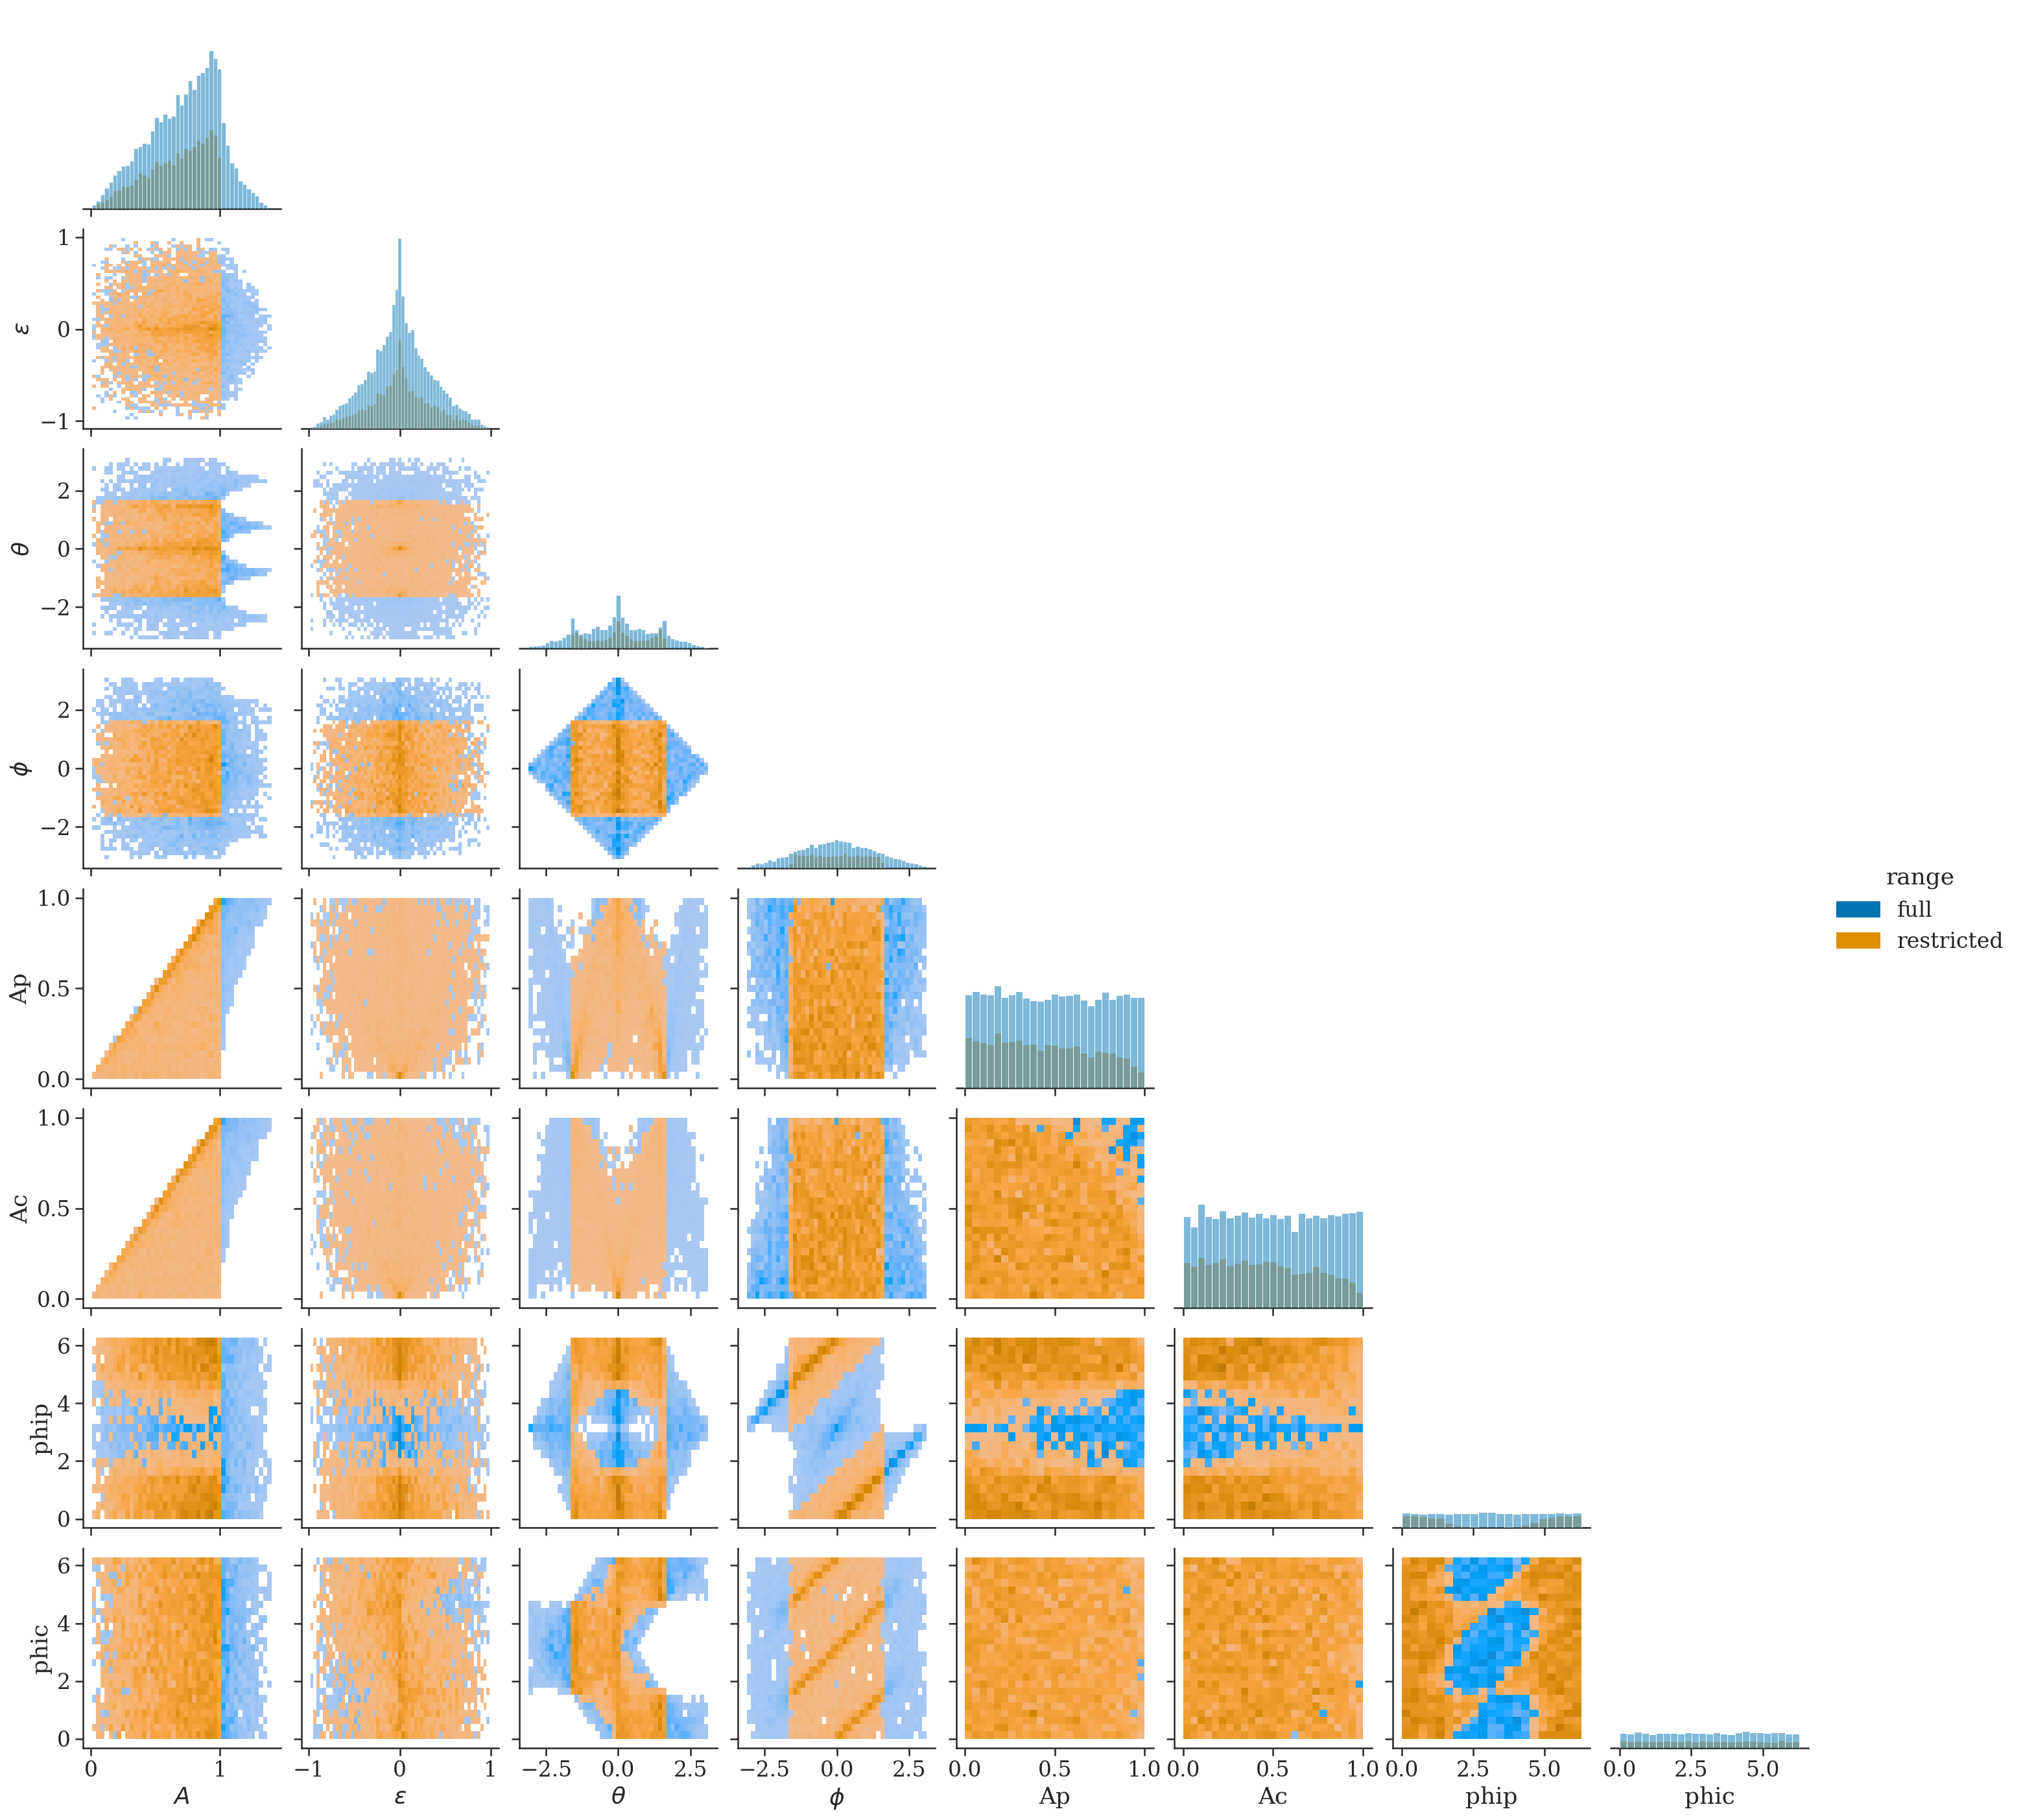

In [857]:
Nplot = 10000#np.inf

ix = rng.choice(len(A), min(Nplot, len(A)), replace=False)
df = pd.DataFrame({'$A$': A[ix], r'$\epsilon$': e[ix], r'$\theta$': theta[ix], r'$\phi$': phi[ix],
                   'Ap': Ap[ix], 'Ac': Ac[ix], 'phip': phip[ix], 'phic': phic[ix]})
df2 = df[(df['$A$']< Amax) & (np.abs(df[r'$\theta$'])< np.pi/2)& (np.abs(df[r'$\phi$'])< np.pi/2)].copy()

# df = df.iloc[:len(df2)]
df['range'] = 'full'
df2['range'] = 'restricted'
df = df.append(df2, ignore_index=True)

ks = ['$A$', r'$\epsilon$', r'$\theta$', r'$\phi$']
sns.pairplot(df, kind='hist', corner=True, hue='range', diag_kws=dict(stat='density'))

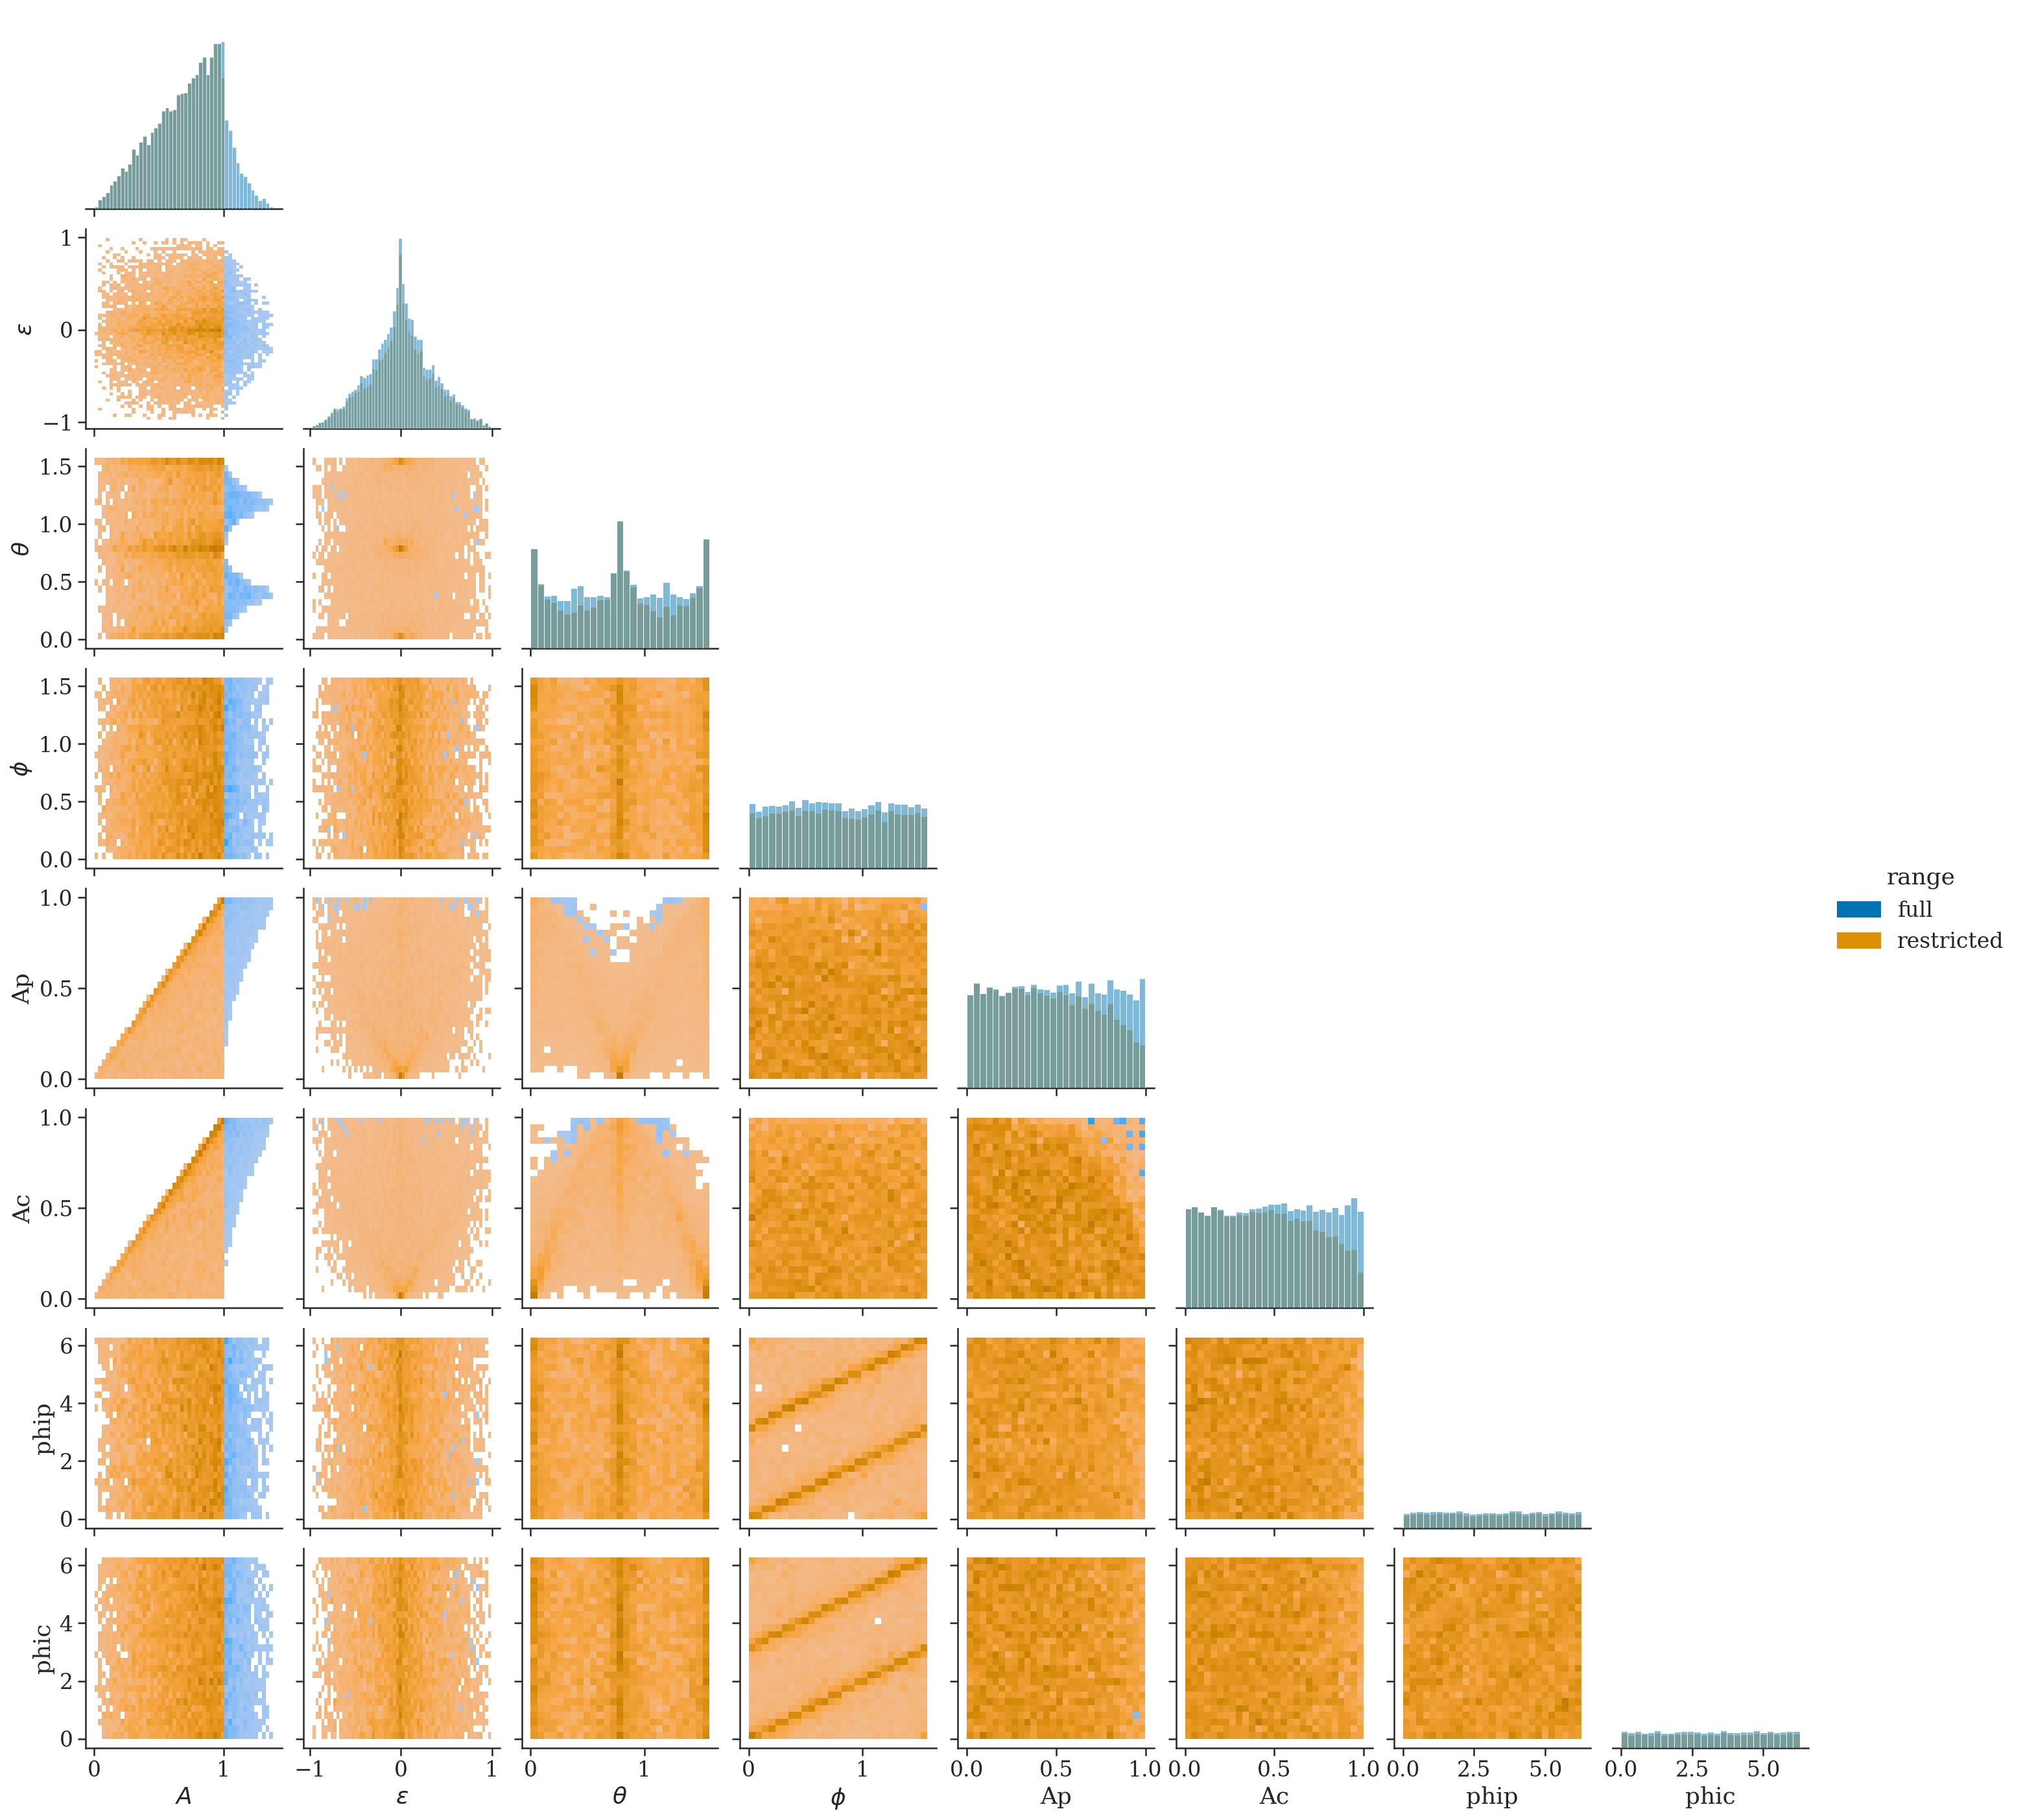

In [813]:
Nplot = 10000#np.inf

ix = rng.choice(len(A), min(Nplot, len(A)), replace=False)
df = pd.DataFrame({'$A$': A[ix], r'$\epsilon$': e[ix], r'$\theta$': theta[ix] % np.pi/2, r'$\phi$': phi[ix] % np.pi/2,
                   'Ap': Ap[ix], 'Ac': Ac[ix], 'phip': phip[ix], 'phic': phic[ix]})
# df2 = df[(df['$A$']< Amax) & (np.abs(df[r'$\theta$'])< np.pi/2)& (np.abs(df[r'$\phi$'])< np.pi/2)].copy()
df2 = df[(df['$A$']< Amax) ].copy()

# df = df.iloc[:len(df2)]
df['range'] = 'full'
df2['range'] = 'restricted'
df = df.append(df2, ignore_index=True)

ks = ['$A$', r'$\epsilon$', r'$\theta$', r'$\phi$']
sns.pairplot(df, kind='hist', corner=True, hue='range', diag_kws=dict(stat='density'))

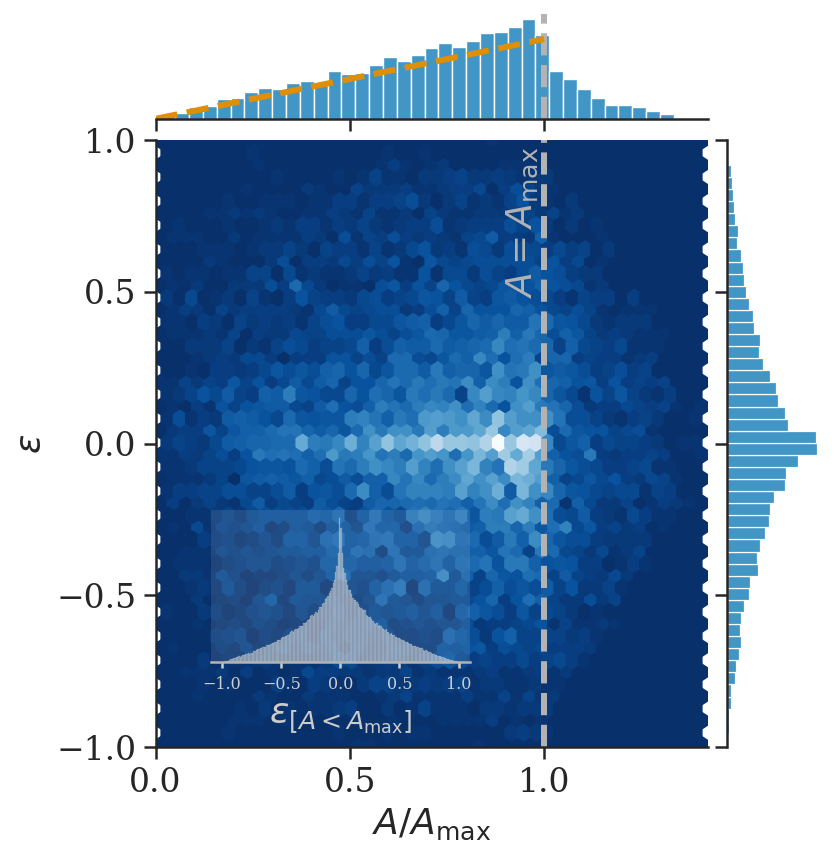

In [484]:
Nplot = 10000

ix = rng.choice(len(A), min(Nplot, len(A)), replace=False)
x = A[ix]
y = e[ix]

g = sns.jointplot(x=x, y=y, xlim=(0, max(A)*1.01), ylim=(-1,1), 
                  kind='hex', joint_kws=dict(cmap='Blues_r'),
                  marginal_kws=dict(stat='density')
                 )

g.ax_joint.set_xlabel(r'$A/A_{\rm max}$')
g.ax_joint.set_ylabel(r'$\epsilon$');

g.ax_joint.set_yticks([-1, -0.5, 0, 0.5, 1])

lkws = dict(c='0.7', ls='--', lw=3)
g.ax_joint.axvline(Amax, **lkws);
g.ax_marg_x.axvline(Amax, **lkws);

# g.ax_joint.tick_params(direction='in')

As = np.linspace(0, Amax, 100)
f = ss.gaussian_kde(A)
g.ax_marg_x.plot(As[As<=Amax], inv_jac_Apc_to_Aep(As[As<=Amax], 0.5, 0)/np.sqrt(2),
           c=sns.color_palette()[1],
          lw=3, ls='--')

cins = '0.8'
axins = g.ax_joint.inset_axes([0.1, 0.14, 0.47, 0.25])
axins.tick_params(labelsize=8, labelcolor=cins, color=cins, length=3)

sns.histplot(e[A<=Amax], ax=axins, stat='density',
             color='0.8', alpha=0.5)

axins.set_xlabel(r'$\epsilon_{[A < A_{\rm max}]}$', color=cins)
axins.set_ylabel(None);
axins.set_yticks([]);
axins.patch.set_alpha(0.1);
for k in ['top', 'right', 'left']:
    axins.spines[k].set_visible(False)
axins.spines['bottom'].set_color('0.7')
# axins.legend(fontsize=10, frameon=False, labelcolor=cins, loc='lower right',
#              handlelength=1, handletextpad=0.5);


g.ax_joint.annotate(r"$A=A_\mathrm{max}$",
            xy=(Amax, 1), xycoords='data', rotation=90,
            xytext=(-2, -3), textcoords='offset points',
            horizontalalignment='right', verticalalignment='top',
            color=lkws['c']);
plt.savefig("jac_Aeps_Apc.pdf", bbox_inches='tight')

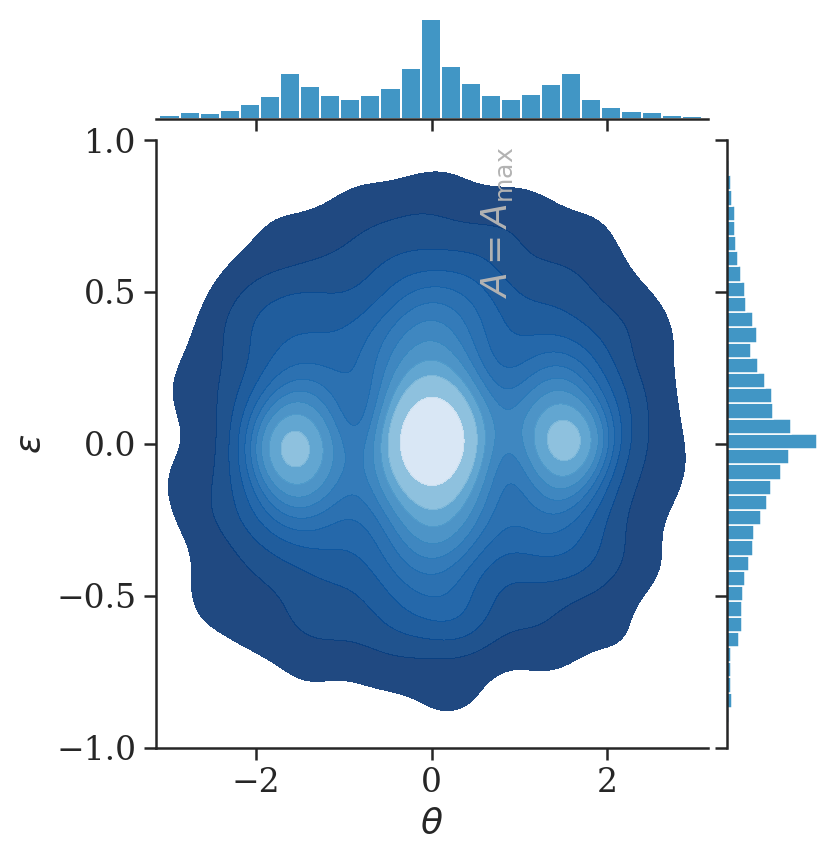

In [485]:
Nplot = 5000

ix = rng.choice(len(A), min(Nplot, len(A)), replace=False)
x = theta[ix][A[ix]<Amax]
y = e[ix][A[ix]<Amax]

g = sns.JointGrid(x=x, y=y, xlim=(-np.pi, np.pi), ylim=(-1,1))
g.plot_joint(sns.kdeplot, clip=((-np.pi, np.pi), (-1,1)), levels=12, fill=True, alpha=0.9, cmap="Blues_r")
g.plot_marginals(sns.histplot)


# g = sns.jointplot(x=x, y=y, xlim=(-np.pi, np.pi), ylim=(-1,1), kind='kde',
#                   joint_kws=dict(clip=((-np.pi, np.pi), (-1,1)), levels=12, fill=True, alpha=0.9))

g.ax_joint.set_xlabel(r'$\theta$')
g.ax_joint.set_ylabel(r'$\epsilon$');

g.ax_joint.set_yticks([-1, -0.5, 0, 0.5, 1])

lkws = dict(c='0.7', ls='--', lw=3)
# g.ax_joint.axvline(Amax, **lkws);
# g.ax_marg_x.axvline(Amax, **lkws);

# g.ax_joint.tick_params(direction='in')

# As = np.linspace(0, Amax, 100)
# g.ax_marg_x.plot(As, inv_jac_Apc_to_Aep(As, 0.5, 0)/1.1,
#            c=sns.color_palette()[1],
#           lw=3, ls='--')

# axins = g.ax_joint.inset_axes([0.1, 0.14, 0.47, 0.25])
# axins.tick_params(labelsize=8, labelcolor='0.4', color='0.4', length=3)

# sns.histplot(e[A<=Amax], ax=axins, stat='density',
#              color='0.8', alpha=0.5)

# # es = np.linspace(-0.999, 0.999, 100)
# # axins.plot(es, np.ones(len(es))/2,
# #            c=sns.color_palette()[1],
# #            label=r'$\propto 1/J$',
# #           lw=3)
# axins.set_xlabel(r'$\epsilon_{[A < A_{\rm max}]}$', color='0.4')
# axins.set_ylabel(None);
# axins.set_yticks([]);
# axins.patch.set_alpha(0.1);
# for k in ['top', 'right', 'left']:
#     axins.spines[k].set_visible(False)
# axins.spines['bottom'].set_color('0.7')
# axins.legend(fontsize=10, frameon=False, labelcolor='0.4', loc='lower right',
#              handlelength=1, handletextpad=0.5);

plt.savefig("jac_Aeps_Apc_theta_kde.pdf", bbox_inches='tight')

## Linear in quadratures

In [92]:
def inv_jac_e(e, normalize=True):
    j = 1-e**2
    if normalize:
        return j / trapz(j, e)
    else:
        return e

def inv_jac_A(A, normalize=True):
    j = A**3
    if normalize:
        return j / trapz(j, A)
    else:
        return j

def inv_jac_Axy_to_Aep(A, e, **kws):
    j =  inv_jac_A(A**kws)*inv_jac_e(e**kws)
    return j

In [107]:
N = 1000000
rng = np.random.default_rng(12345)

# draw uniformly in the original quantities
Axymax = 1
Apx = rng.uniform(-Axymax, Axymax, N)
Apy = rng.uniform(-Axymax, Axymax, N)
Acx = rng.uniform(-Axymax, Axymax, N)
Acy = rng.uniform(-Axymax, Axymax, N)

# transform into linear components
Ap = np.sqrt(Apx**2 + Apy**2)
Ac = np.sqrt(Acx**2 + Acy**2)
phip = np.arctan2(Apy, Apx)
phic = np.arctan2(Acy, Acx)

# transform into circular components
Ar = np.sqrt(Ap**2 + Ac**2 + 2*Ap*Ac*np.sin(phic - phip))/np.sqrt(2)
Al = np.sqrt(Ap**2 + Ac**2 - 2*Ap*Ac*np.sin(phic - phip))/np.sqrt(2)

xp = Ap*np.cos(phip)
yp = Ap*np.sin(phip)
xc = Ac*np.cos(phic)
yc = Ac*np.sin(phic)

phir = np.arctan2(yp - xc, xp + yc)
phil = np.arctan2(yp + xc, xp - yc)

A = (Ar + Al)/np.sqrt(2)
e = (Ar - Al)/(Ar + Al)
theta = (phil - phir)/2
phi = (phil + phir)/2

Ahat = A*np.sqrt(1+e**2)
chi = np.arctan(e)

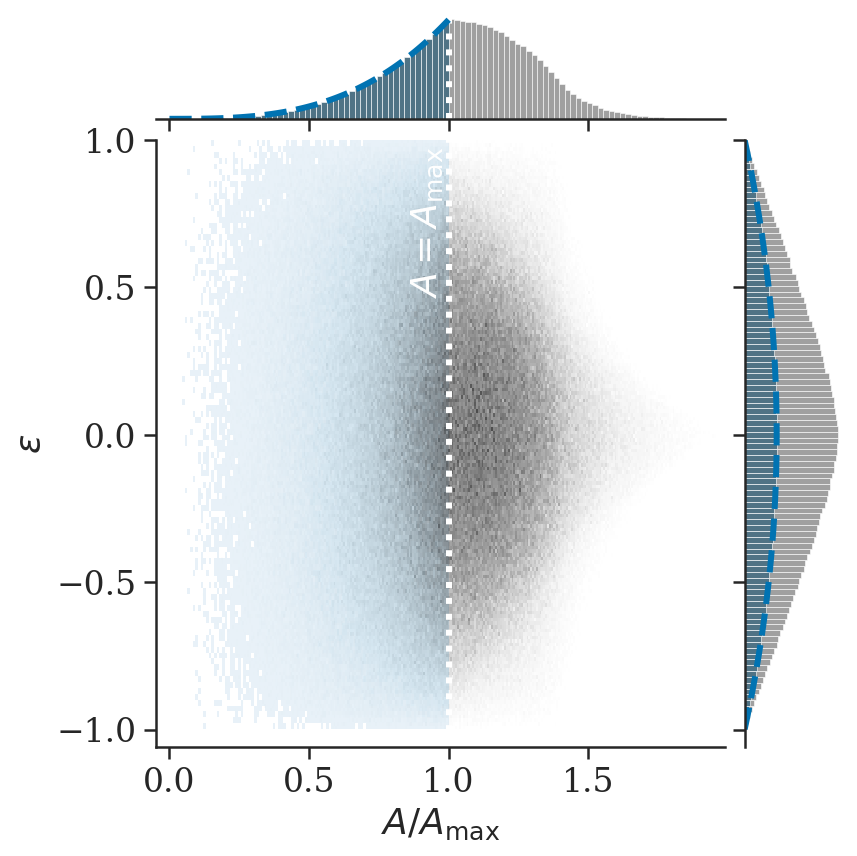

In [108]:
Nplot = np.inf

ix = rng.choice(len(A), min(Nplot, len(A)), replace=False)
x = A[ix]
y = e[ix]

xkdemax = max(A)*1.01
br = (-0.99*xkdemax, xkdemax)
c = sns.color_palette('colorblind', desat=0.4)[0]
marg_kws = dict(binrange=br, bins=200, stat='count')
joint_kws = dict(gridsize=64, extent=[0, xkdemax,-1,1], alpha=0.5)

# g = sns.JointGrid(x=x, y=y, xlim=(-0.05, xkdemax), ylim=(-1.06,1))
# g.plot_joint(sns.histplot, cmap='Greys', alpha=0.9)
# g.plot_marginals(sns.histplot, color='gray', **marg_kws)

# g.x = g.x[x <= Amax]
# g.y = g.y[x <= Amax]
# g.plot_joint(sns.histplot, cmap='Blues', alpha=0.9)
# g.plot_marginals(sns.histplot, color=c, **marg_kws)

g = sns.JointGrid(x=x, y=y, xlim=(-0.05, xkdemax), ylim=(-1.06,1))
g.plot_joint(sns.histplot, cmap='Greys', alpha=.7)#,  **joint_kws)
g.plot_marginals(sns.histplot, color='gray', **marg_kws)

g.x = g.x[x <= Amax]
g.y = g.y[x <= Amax]
g.plot_joint(sns.histplot, bins=100, color=c, alpha=0.25)
g.plot_marginals(sns.histplot, color=c, **marg_kws)

g.ax_joint.set_xlabel(r'$A/A_{\rm max}$')
g.ax_joint.set_ylabel(r'$\epsilon$');
g.ax_joint.set_yticks([-1, -0.5, 0, 0.5, 1])
g.ax_joint.plot([],[], label='full', c='gray')
g.ax_joint.plot([],[], label='restricted', c=c)
# g.ax_joint.legend(framealpha=0.5);

lkws = dict(c='w', ls=':', lw=3)
g.ax_joint.axvline(Amax, **lkws);
g.ax_marg_x.axvline(Amax, **lkws);

As = np.linspace(0, Amax, 100)
cjac = sns.color_palette()[0]

nbins = marg_kws['bins'] * Amax / (0.99*xkdemax)
c = 2*len(g.x) / nbins
g.ax_marg_x.plot(As,  inv_jac_A(As[As<=Amax])*c, lw=3, ls='--', c=cjac)

sns.histplot(e[A<=Amax], ax=axins, stat='density', color='w', alpha=0.5)

es = np.linspace(-0.999, 0.999, 100)
g.ax_marg_y.plot(inv_jac_e(es)*c, es, c=cjac, ls='--', lw=3)

g.ax_joint.annotate(r"$A=A_\mathrm{max}$",
            xy=(Amax, 1), xycoords='data', rotation=90,
            xytext=(-2, -3), textcoords='offset points',
            horizontalalignment='right', verticalalignment='top',
            color=lkws['c']);
plt.savefig("jac_Aeps_Axy.pdf", bbox_inches='tight')

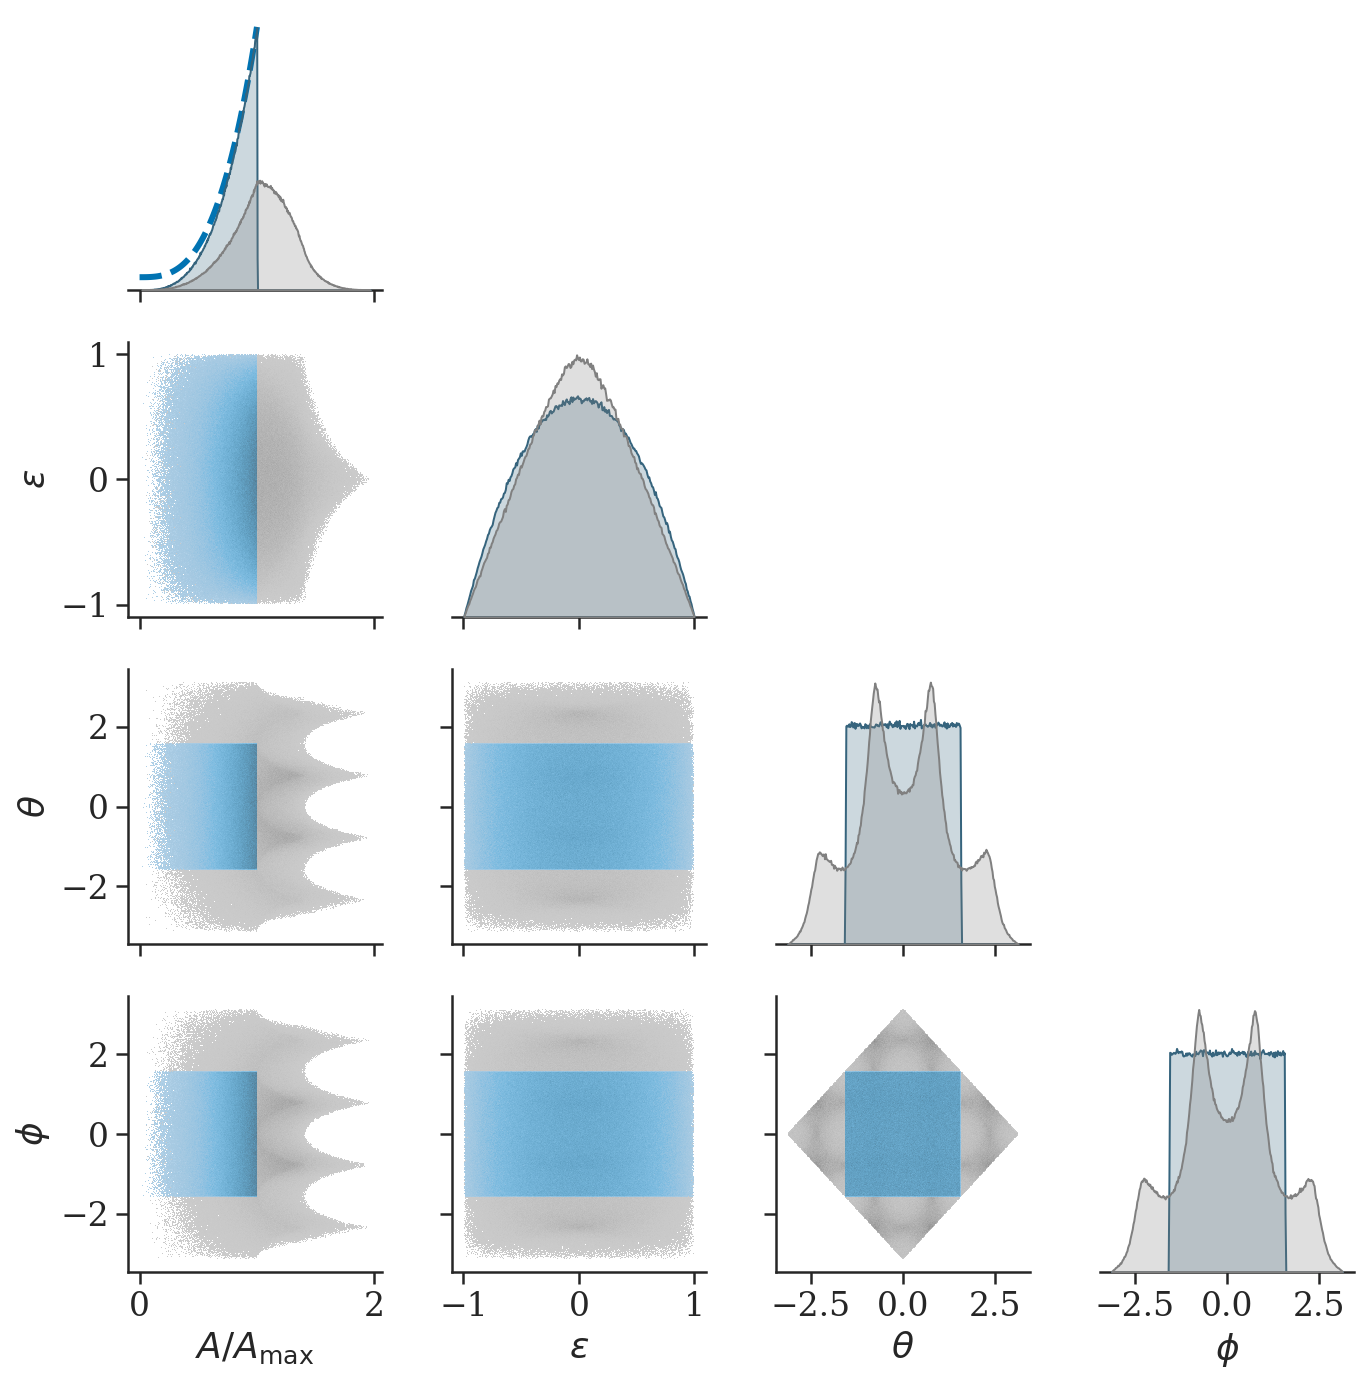

In [105]:
Nplot = len(A)/10  # np.inf

ix = rng.choice(len(A), min(Nplot, len(A)), replace=False)
Akey = r'$A/A_{\rm max}$'
df = pd.DataFrame({Akey: A[ix], r'$\epsilon$': e[ix], r'$\theta$': theta[ix], r'$\phi$': phi[ix],
                   'Apx': Apx[ix], 'Apy': Apy[ix], 'Acx': Acx[ix], 'Acy': Acy[ix]})
df2 = df[(df[Akey]< Amax) & (np.abs(df[r'$\theta$'])< np.pi/2)& (np.abs(df[r'$\phi$'])< np.pi/2)].copy()

df = df.iloc[:len(df2)]
df['range'] = 'full'
df2['range'] = 'restricted'
df = df.append(df2, ignore_index=True)

p = sns.color_palette(['gray', sns.color_palette('colorblind', desat=0.4)[0]])
sns.set(context='notebook', palette=p, style='ticks', font='serif', font_scale=1.5)

ks = [Akey, r'$\epsilon$', r'$\theta$', r'$\phi$', 'range']

Akws = dict(bins=100, binrange=(0, max(A)))
phikws = dict(bins=100, binrange=(-np.pi, np.pi))
g = sns.PairGrid(data=df[ks], hue='range', diag_sharey=False, corner=True, 
                 hue_kws={Akey: Akws, r'$\phi$': phikws})
g.map_lower(sns.histplot, alpha=0.9, rasterized=True)
g.map_diag(sns.histplot, stat='count', element='poly')

# plot Jacobians
As = np.linspace(0, Amax, 100)
nbins = Akws['bins'] * Amax / Akws['binrange'][1]
c = 2*len(df2[Akey]) / nbins
g.axes[0,0].plot(As[As<=Amax], inv_jac_A(As[As<=Amax])*c/10000,
                 c=cjac, lw=3, ls='--')

es = np.linspace(-0.999, 0.999, 100)
yl = g.axes[1,0].get_ylim()
g.axes[1,1].plot(es, inv_jac_e(es)*c, c=cjac, lw=3, ls='--')
for ax in g.axes[1,:]:
    if ax:
        ax.set_ylim(yl)

# for ax in g.axes[:,0]:
#     ax.axvline(Amax, ls=':', lw=3, c='w', zorder=100)

# phis = np.linspace(-np.pi/2, np.pi/2, 100)
# yl = g.axes[-1,0].get_ylim()
# g.axes[-1,-1].plot(phis, np.ones(len(phis))*6*len(df2)/len(df), c=cjac, lw=3, ls='--')
# for ax in g.axes[-1,:-1]:
#     ax.set_ylim(yl)

# ax = g.axes[2,1]
# axins = ax.inset_axes([1.5, 1.5, 1, 1])

# # sub region of the original plot
# x1, x2, y1, y2 = -1, 1, -np.pi/2, np.pi/2

# es = np.linspace(-0.999, 0.999, 2048)
# th = np.linspace(y1, y2, len(es))
# XS, YS = np.meshgrid(es, th, indexing='ij')
# ZS = inv_jac_Apc_to_Aep(1, XS, YS, normalize=False)
# # axins.contourf(XS, YS, np.log(ZS), levels=64, cmap='Blues')
# axins.contour(XS, YS, np.log(ZS), levels=24, colors=[cjac], linewidths=1)

# axins.set_xlim(x1, x2)
# axins.set_ylim(y1, y2)
# axins.set_yticks([-np.pi/2, 0, np.pi/2])
# axins.set_yticklabels([r'$-\pi/2$', '$0$', r'$\pi/2$'])
# axins.set_ylabel(r'$\theta$')
# axins.set_xlabel(r'$\epsilon$')

# axins.plot([], [], c=cjac, lw=3, label=r"$\propto 1/J$")
# axins.legend(loc='upper center', bbox_to_anchor=(0.65, 1.25),
#             frameon=False)

# ax.indicate_inset_zoom(axins, edgecolor="gray")

sns.set(context='notebook', palette='colorblind', style='ticks',
        font='serif', font_scale=1.5)

# plt.savefig("jac_Aeps_Axy_corner.pdf", bbox_inches='tight')

## Inclination

### Forward transformation

In [39]:
def inv_jac_cosi_to_ep(e, normalize=True):
    j = 1/(1 - e**2 + np.sqrt(1 - e**2))
    if normalize:
        return j / trapz(j, e)
    else:
        return j

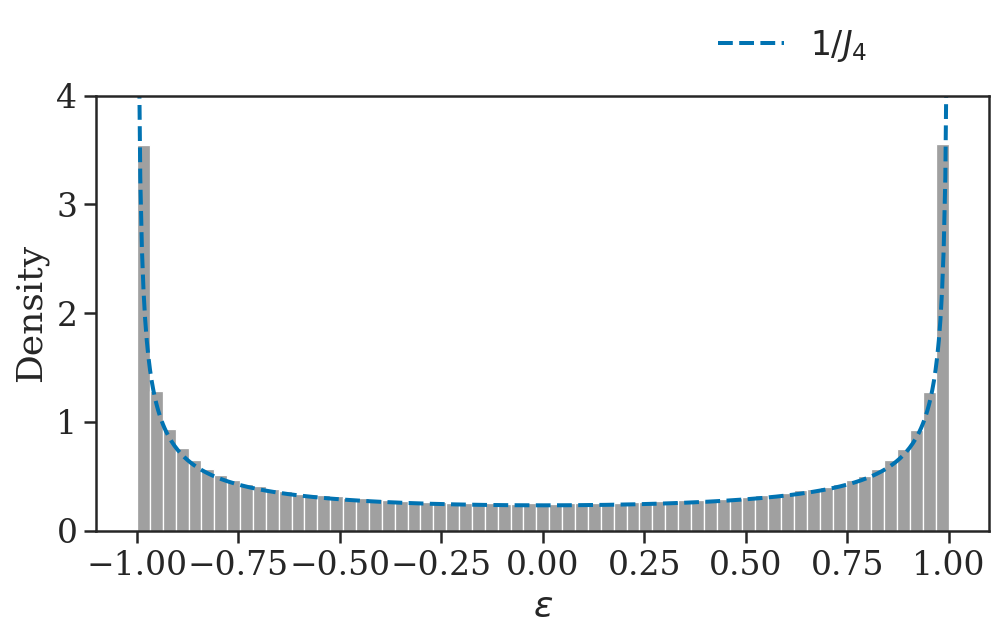

In [97]:
N = 1000000
rng = np.random.default_rng(12345)

# draw uniformly in the original quantities
cosi_fwd = rng.uniform(-1, 1, N)

# transform into A, ellipticity
e_fwd = 2*cosi_fwd / (1 + cosi_fwd**2)

# plot distribution and Jacobian
sns.histplot(e_fwd, stat='density', color='gray')

es = np.linspace(-0.9999, 0.9999, 500)
plt.plot(es, inv_jac_cosi_to_ep(es, normalize=True), label=r'$1/J_4$', lw=2, ls='--')
plt.ylim(0, 4)
plt.legend(loc='upper center', bbox_to_anchor=(0.78, 1.225),
            frameon=False)
plt.xlabel(r'$\epsilon$');
plt.savefig("jac_cosi_to_eps.pdf", bbox_inches='tight')

### Backward transformation

In [95]:
def inv_jac_ep_to_cosi(cosi, normalize=True):
    j = (1- cosi**2)/(1+cosi**2)**2
    if normalize:
        return j / trapz(j, cosi)
    else:
        return j

In [74]:
sns.set(context='notebook', palette='colorblind', style='ticks',
        font='serif', font_scale=1.5)

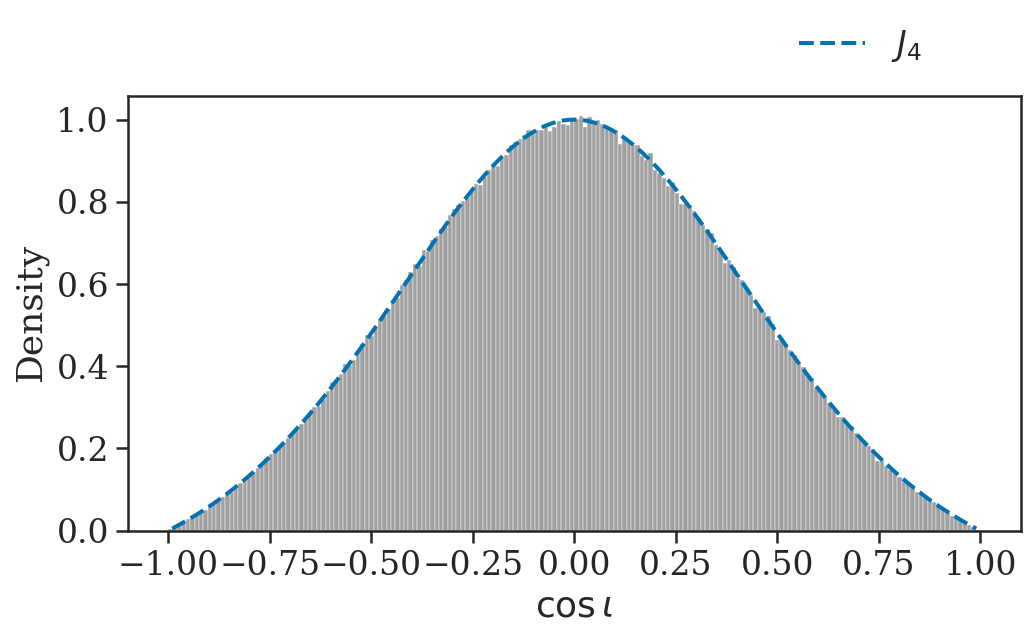

In [101]:
N = 1000000
rng = np.random.default_rng(12345)

# draw uniformly in the original quantities
e_bwd = rng.uniform(-1, 1, N)

# transform into A, ellipticity
cosi_bwd = (1- np.sqrt(1 - e_bwd**2))/e_bwd

# plot distribution and Jacobian
sns.histplot(cosi_bwd, stat='density', color='gray')

cosis = np.linspace(-0.99, 0.99, 500)
plt.plot(cosis, inv_jac_ep_to_cosi(cosis), label=r'$J_4$', lw=2, ls='--')
plt.legend(loc='upper center', bbox_to_anchor=(0.82, 1.225),
            frameon=False)
plt.xlabel(r'$\cos\iota$');
plt.savefig("jac_eps_to_cosi.pdf", bbox_inches='tight')

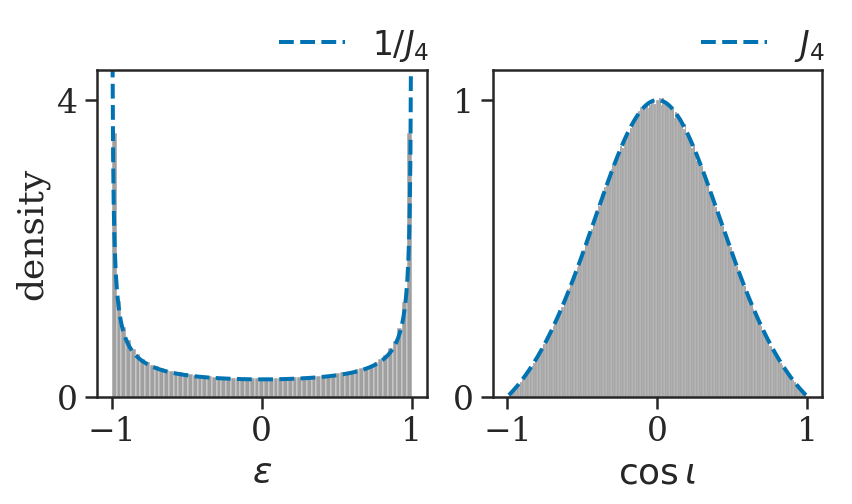

In [112]:
fig, axs = plt.subplots(1, 2, figsize=(6.5, 3))

ax = axs[0]
sns.histplot(e_fwd, stat='density', color='gray', ax=ax)
ax.plot(es, inv_jac_cosi_to_ep(es, normalize=True), label=r'$1/J_4$', lw=2, ls='--')
ax.set_ylim(0, 4.4)
ax.legend(loc='upper center', bbox_to_anchor=(0.78, 1.225),
            frameon=False)
ax.set_xlabel(r'$\epsilon$');

ax = axs[1]
sns.histplot(cosi_bwd, stat='density', color='gray', ax=ax)
ax.plot(cosis, inv_jac_ep_to_cosi(cosis), label=r'$J_4$', lw=2, ls='--')
ax.legend(loc='upper center', bbox_to_anchor=(0.82, 1.225),
            frameon=False)
ax.set_xlabel(r'$\cos\iota$');

axs[0].set_yticks([0, 4])
axs[1].set_yticks([0, 1])
axs[1].set_ylim([0, 1.1])
axs[0].set_ylabel('density');
axs[1].set_ylabel('');
fig.savefig("jac_eps_cosi.pdf", bbox_inches='tight')